In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from numba import njit
from scipy import odr
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
from scipy import stats as st
import time

os.chdir('F:/LANL/')
# os.chdir('/mnt/c/Users/gabeo/Desktop/analysis_temp/')
root = os.getcwd()

processedfolder = '/processed_data/'
vconstantsavename = root+processedfolder+'s_vparams_La'  ## MAKE SURE TARGET IS CORRECT !

search_arr = sorted(os.listdir(root + processedfolder))
print('Searhing in array (sorted): ', search_arr)
# print(search_arr[0])
folders_start = 'runs'+'12034-12363'
folders_end = 'runs'+'12364-12684'
print(folders_start)
start_i = search_arr.index(folders_start)
end_i = search_arr.index(folders_end)
print('Indices in above array, starti-endi:', start_i,'-', end_i)
# print(len(search_arr[start_i:end_i+1]))

folderslist = []
if folders_start == folders_end:
    currfolder = search_arr[start_i]+'/'
    folderslist.append(currfolder)
else:
    for f in range(start_i, end_i+1):
#         print(f)
#         print(search_arr[f])
        currfolder = root+processedfolder+search_arr[f]
        currfolder = search_arr[f]+'/'
        print(currfolder)
        folderslist.append(currfolder)
#     runslist_D[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D'))
#     runslist_U[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_U'))

numfolders = len(folderslist)
print(numfolders, 'folders, array of folders is: ', folderslist)

## change below to multiple folders?
runslist_D = []  ## array of runfolders, runs
runslist_U = []
for i in range(len(folderslist)):
    runslist_D.append(sorted(os.listdir(root+processedfolder+folderslist[i]+'/pulseadd_D')))
    runslist_U.append(sorted(os.listdir(root+processedfolder+folderslist[i]+'/pulseadd_U')))
# runslist_D = sorted(os.listdir(root+processedfolder+folders_start+'/ONOFF_D')) ## has to be changed to an array
# runslist_U = sorted(os.listdir(root+processedfolder+folders_start+'/ONOFF_U'))
# runslist_D =np.asarray(runslist_D)
# runslist_U =np.asarray(runslist_U)
print(len(runslist_D))
print(len(runslist_D[0]))
print(len(runslist_D[1]))
## now flatten list so that all runs are in one array ## not sure I will use this
flatrunslist_D = [run for folder in runslist_D for run in folder]
flatrunslist_D = np.asarray(flatrunslist_D)
flatrunslist_U = [run for folder in runslist_U for run in folder]
flatrunslist_U = np.asarray(flatrunslist_U)
print(len(flatrunslist_D))

numruns_tot_D = len(flatrunslist_D) ## U and D should be the same? ## should change to num pulses maybe
numruns_tot_U = len(flatrunslist_U) ## 
print(numruns_tot_D)
print(numruns_tot_U)


Searhing in array (sorted):  ['0_vparams_La.h5', '1_vparams_Pr.h5', 'La_sample', '_temp_xs.npy', 'runs07862-08069', 'runs09919-10159', 'runs11121-11138', 'runs11139-11412', 'runs11413-11726', 'runs11727-12033', 'runs12034-12363', 'runs12364-12684', 'runs12686-13279', 'runs13280-13563', 'runs13564-13604', 'runs13605-13735', 'runs13736-13851', 'runs13852-14191', 'runs14192-14499', 'runs14500-15106', 'runs15114-15568', 'runs15569-16110', 'runs16135-16392', 'runs16453-16763', 'runs88888-99999', 's_vparams_La.h5', 'xs_cut.npy', 'xs_uncut.npy']
runs12034-12363
Indices in above array, starti-endi: 10 - 11
runs12034-12363/
runs12364-12684/
2 folders, array of folders is:  ['runs12034-12363/', 'runs12364-12684/']
2
330
318
648
648
648


In [2]:
plt.rcParams.update({
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'xtick.minor.visible': 'True',
    'ytick.minor.visible': 'True',
    'axes.grid': 'True',
    'axes.grid.which': 'both',
    'grid.alpha': '0.50',
    'grid.linestyle': ':',
    'legend.fontsize': 'medium',
    'figure.figsize': '10.0, 7.0',
    'backend': 'Qt5agg',
    'interactive': 'True',
    'figure.autolayout': 'True',
})
%matplotlib qt
print('updated rcparam')

updated rcparam


# Need to get num pulses!!! ending runs dont have as many pulses !!

In [3]:
## load in the x array. Also helps in determining sizes
channels_all = []
folderpath = root+processedfolder+folderslist[0]
with h5py.File(folderpath+'/pulseadd_D/'+runslist_D[0][0], 'r') as f: ## new arr_sizer
    channels_D = list(f.keys())
    channels_all.append(channels_D[:-2])
    numchannels = len(channels_D)-1
    dataset = f[channels_D[-1]]   ## this is the xs dataset
    xs = np.array(dataset)*1e-6 ## now in ms
    numpoints = len(xs)
    f.close()
    
with h5py.File(folderpath+'/pulseadd_U/'+runslist_U[0][0], 'r') as f: ## new arr_sizer
    channels_U = list(f.keys())
    channels_all=np.append(channels_all, channels_U[:-1])
#     channels_all.append(channels[:-1])
    numchannels = len(channels_U)-1
    dataset = f[channels_U[-1]]   ## this is the xs dataset
    xs = np.array(dataset)*1e-6 ## now in ms
    numpoints = len(xs)
    f.close()
# print(channels_all)
# channels_all = np.asarray(channels_all, dtype=object)
# print(channels_all)
# channels_all = channels_all.flatten()
print(numruns_tot_D,numchannels,numpoints)
# print(data.shape)
# print(data[seq][0][0])
print(channels_all[:])
print(channels_all[-1])
print(len(xs))
print(channels_D)
print(channels_U)

print(channels_all)

# print(channels_all.flatten())
# print(data)

648 13 8992
['ch_00' 'ch_01' 'ch_02' 'ch_03' 'ch_04' 'ch_05' 'ch_06' 'ch_07' 'ch_08'
 'ch_09' 'ch_10' 'ch_11' 'ch_12' 'ch_13' 'ch_14' 'ch_15' 'ch_16' 'ch_17'
 'ch_18' 'ch_19' 'ch_20' 'ch_21' 'ch_22' 'ch_23' 'ch_24']
ch_24
8992
['ch_00', 'ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07', 'ch_08', 'ch_09', 'ch_10', 'ch_11', 'ch_24', 'xs ']
['ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23', 'ch_24', 'xs ']
['ch_00' 'ch_01' 'ch_02' 'ch_03' 'ch_04' 'ch_05' 'ch_06' 'ch_07' 'ch_08'
 'ch_09' 'ch_10' 'ch_11' 'ch_12' 'ch_13' 'ch_14' 'ch_15' 'ch_16' 'ch_17'
 'ch_18' 'ch_19' 'ch_20' 'ch_21' 'ch_22' 'ch_23' 'ch_24']


In [4]:

def loadrun_pulseadd(run, processedpath): ## not sure if this is the fastest way, or passing a list of runs...
    runname = processedpath+run
#     print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        arrsizer = f[channels[-1]] ## gets the xs array
        arrsizer = np.asarray(arrsizer)
        numpoints = len(arrsizer)
#             num_seq = f.attrs.get('sequences')
#             numsequences.append(num_seq)
        rundat = np.zeros((numchannels,numpoints),dtype = np.float64)
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        for i in range(0,numchannels):
            dataset = f[channels[i]+'/added_pulses/'+channels[i]][:]  ##change this to match channels[i]
            chdata = np.array(dataset)
#                     print(chdata)
#                     print(np.size(chdata))
#                     print(len(chdata[0]))
#                     print(rundat)
            rundat[i] = rundat[i]+chdata
        f.close()
    return rundat

start=time.time()
# all_D = [] ## in this case cannot be np array because it is not same size arrays ## will be run, channel, numpoints
# all_D = np.zeros((numruns_tot_D, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
# all_U = np.zeros((numruns_tot_U, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
all_D = []
all_U = []

for f in range(0,len(folderslist)):
    fpath = root+processedfolder+folderslist[f]
    for r in range(0, len(runslist_D[f])):
#         print(runslist_D[f][r])
#         all_D.append(loadrun_pulseadd(runslist_D[f][r], fpath+'/pulseadd_D/'))
#         print(r)
#         all_D[r] = loadrun_pulseadd(runslist_D[f][r], fpath+'/pulseadd_D/')
#         all_U[r] = loadrun_pulseadd(runslist_U[f][r], fpath+'/pulseadd_U/')
        all_D.append(loadrun_pulseadd(runslist_D[f][r], fpath+'/pulseadd_D/'))
        all_U.append(loadrun_pulseadd(runslist_U[f][r], fpath+'/pulseadd_U/'))
#         print(all_D[r])
    print(fpath+' done')

all_D = np.asarray(all_D)
all_U = np.asarray(all_U)
    
end=time.time()
print('loaded files time: ', end-start)

F:\LANL/processed_data/runs12034-12363/ done
F:\LANL/processed_data/runs12364-12684/ done
loaded files time:  57.578325271606445


In [5]:
print(len(folderslist))
print(len(runslist_D[1]))
print(runslist_D[1][0])

2
318
12364_pulseadd_D.h5


In [6]:
# test_D = np.zeros((numchannels,numpoints),dtype = np.float64)
# test_D = loadrun_pulseadd(runslist_D[1][0],'F:\LANL/processed_data/runs12364-12684/'+'/pulseadd_D/')
# print(test_D)

### before fitting, realign spec. Especially important for s-wave and higher energy res.


In [7]:
def g_flash_off(ys, search_region=(1800,2200), threshold_frac=0.3):
    # print(ys)
    seg = ys[search_region[0]:search_region[1]]
    # print(seg)
    n = seg.size
    baseline = np.median(seg[:max(1, n//10)])
    peak = np.max(seg)
    thr = baseline + threshold_frac*(peak - baseline) ## sets threshold dynamically based on gamma flash amp.
    idxs = np.where(seg > thr)[0]
    if idxs.size == 0: ## if no gamma flash is detected, then put a special flag
        return -1
    for ii in idxs:
        if ii+1 < n and seg[ii+1] >= seg[ii]:
            return search_region[0] + ii
    return search_region[0] + idxs[0]

def align_spec(ys_ch, gflash_bin, fill_unchanged=True):
    """Return ys rolled by -(gflash_bin - median_flash) per run."""
    detected = gflash_bin >= 0  ## checks if a gflash was detected, see g_flash_off f(x)
    if np.any(detected):
        median_flash = int(np.median(gflash_bin[detected]))
    else:
        median_flash = 0
    offsets = np.zeros(len(gflash_bin), dtype=int)
    offsets[detected] = gflash_bin[detected] - median_flash
    ys_roll = np.empty_like(ys_ch)
    for r in range(len(gflash_bin)):
        if (gflash_bin[r] < 0) and fill_unchanged:
            ys_roll[r] = ys_ch[r].copy()
        else:
            ys_roll[r] = np.roll(ys_ch[r], -offsets[r])
    return ys_roll, offsets

In [8]:
if all_D.shape[0] != all_U.shape[0]:
    emessage = ('Downstream and Upstream do not have equal # runs!')
    raise Exception(emessage)

offs_D = []
offs_U = []
for ch in range(0, all_D.shape[1]): # for every channel
    offs_ch_D = []
    offs_ch_U = []
    for r in range(0, all_D.shape[0]): # for every run
        bin_i_D = g_flash_off(all_D[r,ch])
        bin_i_U = g_flash_off(all_U[r,ch])
        offs_ch_D.append(bin_i_D)
        offs_ch_U.append(bin_i_U)
    offs_D.append(offs_ch_D)
    offs_U.append(offs_ch_U)
offs_D, offs_U = np.array(offs_D), np.array(offs_U)

print((offs_D.shape), (offs_U.shape))
print(offs_D[1,10:20], offs_U[1,10:20])

rolled_D = []
rolled_U = []
for ch in range(0, all_D.shape[1]): # for every channel
    rolled_ch_D, _ = align_spec(all_D[:,ch], offs_D[ch])
    rolled_ch_U, _ = align_spec(all_U[:,ch], offs_U[ch])
    rolled_D.append(rolled_ch_D)
    rolled_U.append(rolled_ch_U)
    
rolled_D, rolled_U = np.array(rolled_D).transpose(1, 0, 2), np.array(rolled_U).transpose(1, 0, 2) ## goes back to [run, ch, points] for consistency

print((rolled_D.shape), (rolled_U.shape))


(13, 648) (13, 648)
[1994 1994 1994 1993 1993 1993 1994 1994 1994 1993] [1994 1994 1994 1993 1993 1993 1994 1994 1994 1993]
(648, 13, 8992) (648, 13, 8992)


In [11]:
ch = 1
plt.plot(all_D[0][ch], ls = '-', label='old')
plt.plot(all_D[2][ch], ls = '-', label='old')
plt.plot(rolled_D[0][ch], ls = '--', label='new')
plt.plot(rolled_D[2][ch], ls = '--', label='new')

plt.plot(all_U[0][ch], ls = '-', label='old U')
plt.plot(all_U[2][ch], ls = '-', label='old U')
plt.plot(rolled_U[0][ch], ls = '--', label='new U')
plt.plot(rolled_U[2][ch], ls = '--', label='new U')

plt.legend()
plt.xlim(1985,2100)
plt.show()

In [10]:
## redefine all_D to shifted ones. keeps names consistent afterward.

all_D, all_U = rolled_D, rolled_U

## using pulseadd to find best values for voigt fits. Get fit values for every run (to get a distribution of x_loc, sig, gam

In [11]:
def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

m_n = 1.6749286*10**(-27)
# L = 0
J_to_eV = 6.24151*10**18
eV_to_J = 1.602176565*10**-19

fpl = 23.31


def tof_to_eV(xtof, FPlength, t_off):
    m_n = 1.6749286*10**(-27)
    delay = t_off
    x_eV_out = 0.5*m_n*((FPlength/((xtof+delay)/1000)))**2*J_to_eV  ## tof in ms
    return x_eV_out
def eV_to_tof(xeV, FPlength, t_off):
    m_n = 1.6749286*10**(-27)
    delay = t_off
    x_tof_out = delay + 1000*FPlength*np.sqrt(m_n/(2*xeV*eV_to_J))  ## tof in ms
    return x_tof_out

In [12]:
## try with chat gpt lol

In [13]:
@njit
def polyN_fit_errors(x, y, degree):
    """Fit y = a0*x^n + a1*x^(n-1) + ... + an using least squares and return errors.
Parameters:
        x : 1D array of inputs
        y : 1D array of outputs
        degree : int, degree of polynomial
Returns:
        coeffs : array of fitted coefficients [a0, a1, ..., an]
        stderr : array of standard errors (1-sigma) for each coefficient"""
    n = x.shape[0]
    A = np.empty((n, degree + 1))
    for i in range(n):
        xi = x[i]
        A[i, degree] = 1.0
        for j in range(degree - 1, -1, -1):
            A[i, j] = A[i, j + 1] * xi

    ATA = A.T @ A
    ATy = A.T @ y
    coeffs = np.linalg.solve(ATA, ATy)

    # Calculate residuals and variance
    y_fit = A @ coeffs
    residuals = y - y_fit
    dof = n - (degree + 1)
    residual_variance = np.sum(residuals**2) / dof

    # Covariance matrix and standard errors
    cov_matrix = np.linalg.inv(ATA) * residual_variance
    stderr = np.sqrt(np.diag(cov_matrix))

    return coeffs, stderr

def polyN_predict(x, coeffs):
    """Evaluate polynomial at x using Horner's method.
Parameters:
        x : 1D array of input data
        coeffs : 1D array of coefficients [a0, a1, ..., an]
Returns:
        y : predicted values"""
    n = x.shape[0]
    y = np.empty(n)
    degree = coeffs.shape[0]
    for i in range(n):
        xi = x[i]
        yi = coeffs[0]
        for j in range(1, degree):
            yi = yi * xi + coeffs[j]
        y[i] = yi
    return y

# @njit  ### this doesn't work right now
# def polyN_residuals(x, y, coeffs):
#     """
#     Compute residuals y - y_fit.
#     """
#     y_fit = polyN_predict(x, coeffs)
#     return y - y_fit

In [14]:
## try the function to also output reduced chi square for determining goodness of fit

@njit
def polyN_fit_chi2(x, y, degree):
    """
    Fit a polynomial of given degree to (x, y) using least squares.

    Returns:
        coeffs : fitted polynomial coefficients [a0, a1, ..., an]
        stderr : standard errors (1-sigma) of the coefficients
        red_chi2 : reduced chi-squared (chi2 / dof), assumes sigma_i = 1
    """
    n = x.shape[0]
    A = np.empty((n, degree + 1))
    for i in range(n):
        xi = x[i]
        A[i, degree] = 1.0
        for j in range(degree - 1, -1, -1):
            A[i, j] = A[i, j + 1] * xi

    ATA = A.T @ A
    ATy = A.T @ y
    coeffs = np.linalg.solve(ATA, ATy)

    # Predicted values and residuals
    y_fit = A @ coeffs
    residuals = y - y_fit

    dof = n - (degree + 1)
#     dof=1
    chi2 = np.sum(residuals**2)
    red_chi2 = chi2 / dof

    cov_matrix = np.linalg.inv(ATA) * red_chi2
    stderr = np.sqrt(np.diag(cov_matrix))

    return coeffs, stderr, red_chi2

@njit
def polyN_fit_chi2_w(x, y, sigma, degree):
    """
    Weighted least squares polynomial fit of any degree.

    Parameters:
        x : 1D array of input data
        y : 1D array of target data
        sigma : 1D array of standard deviation (uncertainty) of each y
        degree : degree of the polynomial

    Returns:
        coeffs : polynomial coefficients [a0, a1, ..., an]
        stderr : standard error (1-sigma) of each coefficient
        red_chi2 : reduced chi-squared of the fit
    """
    n = x.shape[0]
    A = np.empty((n, degree + 1))
    for i in range(n):
        xi = x[i]
        A[i, degree] = 1.0
        for j in range(degree - 1, -1, -1):
            A[i, j] = A[i, j + 1] * xi

    # Apply weights: divide rows by sigma
    for i in range(n):
        for j in range(degree + 1):
            A[i, j] /= sigma[i]

    y_weighted = y / sigma

    ATA = A.T @ A
    ATy = A.T @ y_weighted
    coeffs = np.linalg.solve(ATA, ATy)

    # Residuals and reduced chi-squared
    y_fit = A @ coeffs
    residuals = y_weighted - y_fit
    chi2 = np.sum(residuals**2)
    dof = n - (degree + 1)
    red_chi2 = chi2 / dof

    cov_matrix = np.linalg.inv(ATA) * red_chi2
    stderr = np.sqrt(np.diag(cov_matrix))

    return coeffs, stderr, red_chi2

def polyN_fit_chi2_w2(x, y, sigma, degree):
    """
    Weighted least squares polynomial fit of any degree.
    
    Returns:
        coeffs : polynomial coefficients
        stderr : 1-sigma error for each coefficient
        red_chi2 : reduced chi-squared
        residuals : y - y_fit (unweighted)
    """
    n = x.shape[0]
    A = np.empty((n, degree + 1))
    for i in range(n):
        xi = x[i]
        A[i, degree] = 1.0
        for j in range(degree - 1, -1, -1):
            A[i, j] = A[i, j + 1] * xi

    # Apply weights
    for i in range(n):
        for j in range(degree + 1):
            A[i, j] /= sigma[i]
    y_weighted = y / sigma

    ATA = A.T @ A
    ATy = A.T @ y_weighted
    coeffs = np.linalg.solve(ATA, ATy)

    # Compute fitted values and residuals
    y_fit = A @ coeffs
    residuals = y_weighted - y_fit

    chi2 = np.sum(residuals**2)
    dof = n - (degree + 1)
#     dof=1
    red_chi2 = chi2 / dof

    cov_matrix = np.linalg.inv(ATA) * red_chi2
    stderr = np.sqrt(np.diag(cov_matrix))

    # Convert residuals back to original units
    res_unweighted = (y_weighted - y_fit) * sigma

    return coeffs, stderr, red_chi2, res_unweighted

In [15]:
##rebinning functions

from functools import reduce
def factors(n):
    return set(reduce(list.__add__,([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

bg_region1_beg = 3250
bg_region1_end = 3650
bg_region2_beg = 4100
bg_region2_end = 5500
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]

x1 = np.arange(bg_reg1[0], bg_reg1[1],1)
x2 = np.arange(bg_reg2[0], bg_reg2[1],1)
x = np.append(x1,x2)
fullx = np.arange(bg_reg1[0], bg_reg2[1],1)

print(len(fullx))
rebinfactors = np.sort(np.array(list(factors(len(fullx)))))
print(f'possible factors are ', rebinfactors)

rebinf = rebinfactors[3]
print(f'using factor {rebinf}')

2250
possible factors are  [   1    2    3    5    6    9   10   15   18   25   30   45   50   75
   90  125  150  225  250  375  450  750 1125 2250]
using factor 5


3
Fitted Coefficients: [-3.48091279e-08  5.13767404e-04 -2.54734741e+00  4.33784079e+03]
Uncertainty:  [8.34201420e-10 1.09533793e-05 4.73720827e-02 6.73874686e+01]
reduced chi squared:  1.1587470012423018
('max y:', np.float64(301.50671453467544))
residuals: [25.92097428  7.33829705 19.32007737 ...  7.30490956  4.31230719
 -0.20608028]
residuals mean: 4.0447029937751395

4
Fitted Coefficients: [ 2.09305123e-11 -4.02453852e-07  2.91580367e-03 -9.46305371e+00
  1.17375726e+04]
Uncertainty:  [1.32990292e-12 2.33727124e-08 1.52964316e-04 4.41631868e-01
 4.74352377e+02]
reduced chi squared:  1.007713637617984
('max y:', np.float64(301.50671453467544))
residuals: [19.70000741  1.1817011  13.22759298 ...  2.62934949 -0.41064721
 -4.97664437]
residuals mean: 3.745358480652936

5
Fitted Coefficients: [-6.80574522e-15  1.68732981e-10 -1.67754675e-06  8.37707189e-03
 -2.10744775e+01  2.15411894e+04]
Uncertainty:  [2.46064660e-15 5.34551003e-11 4.61605056e-07 1.98043735e-03
 4.22123238e+00 3.5760

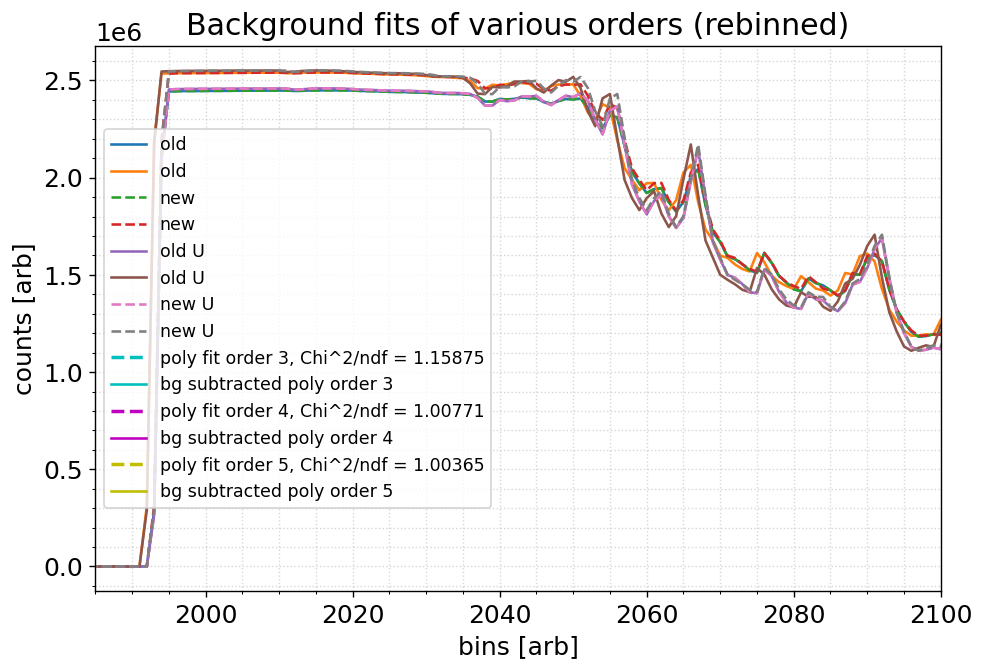

[array([18.8342311 ,  0.32944262, 12.38875377, ...,  3.63655684,
        0.61169795, -3.93905757], shape=(2100,))]
8.197958946228027 sec


In [16]:
## plot different orders of polynomial
## can I scale chi2 by a constant value?

%matplotlib inline

bg_region1_beg = 3300
bg_region1_end = 3650
bg_region2_beg = 4100
bg_region2_end = 5400
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]

start = time.time()
aft_res_reg = bg_reg2
bef_res_reg = bg_reg1

binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
x = np.append(x1,x2)

fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
ys_bgsub = []

ys = all_D[0][0]

fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
datasplice = np.append(fitdata1, fitdata2)
y = datasplice
linecolors = ['lies','g','r','c','m','y']
f = 100

plt.plot(fullx, ys[bef_res_reg[0]: aft_res_reg[1]]/f)
rebinf = 10
allchi2 = []
y_scaled = (y)/f
y = y_scaled
sigma = np.full_like(x, 1)

coeffs, errs, chi2, residuals = polyN_fit_chi2_w2(x,y,sigma,5) ## use residuals from 5th order poly as sigmas
sigma_from_resid = np.full_like(y_scaled, np.std(residuals))
sigma = sigma_from_resid

for i in range(3,6):
    # Fit model
    print(i)
    coeffs, errs, chi2 = polyN_fit_chi2_w(x,y,sigma,i)
    print("Fitted Coefficients:", coeffs)
    print('Uncertainty: ', errs)
    print('reduced chi squared: ', chi2)
    # Predict
    y_fit = polyN_predict(x, coeffs)
    fullpoly_y2 = polyN_predict(fullx, coeffs)

    ys_bgsub=[]
    bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]]/f - fullpoly_y2  ## subtracts RealData-BackgroundFit
    ys_bgsub.append(bgsubtracted)
    ys_bgsub[0] ## the array notation is left over from before...
    chi2 = np.round(chi2,5)
    plt.plot(x, y_fit, label = rf'poly fit order {i}, Chi^{2}/ndf = {chi2}', ls = '--', c=linecolors[i], lw = '2')
#     plt.plot(fullx, ys_bgsub[0], label = rf'bg subtracted poly order {i}',c=linecolors[i])
    y_plotrebin, xs_plotrebin = rebin(ys_bgsub[0], fullx, rebinf)
    plt.plot(xs_plotrebin,y_plotrebin, label = rf'bg subtracted poly order {i}',c=linecolors[i])
    print(("max y:", np.max(y)))
    print("residuals:", y - y_fit)
    print("residuals mean:", np.mean(np.abs(y - y_fit)))
    print()

plt.title(rf'Background fits of various orders (rebinned)', fontsize = 'xx-large')

plt.grid(True, which='both', alpha = 0.5, ls = ':')
plt.minorticks_on()
plt.xticks(fontsize = 'x-large')
plt.yticks(fontsize = 'x-large')

plt.ylabel('counts [arb]',fontsize = 'x-large')
plt.xlabel('bins [arb]',fontsize = 'x-large')

plt.legend(fontsize = 'medium')
plt.show()

print(ys_bgsub)

end = time.time()
print(end-start, 'sec')
# plt.plot(x, y_fit)

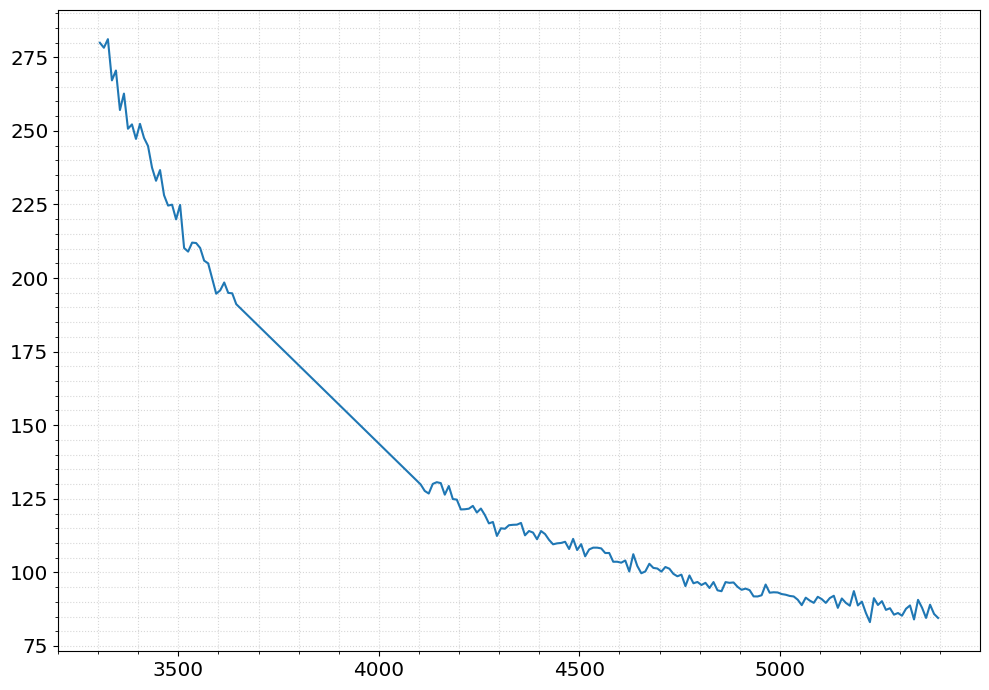

In [18]:
## for plotting
%matplotlib inline

rebinf = 10
y_plotrebin, xs_plotrebin = rebin(y, x, rebinf)
# All_Li6_asyms_rebin8, xs_plotrebin = rebin(All_Li6_asyms, xs_cut[0], rebinf)

# print(len(All_NaI_asyms_rebin8))
# print(len(xs_cut_rebin8))
plt.plot(xs_plotrebin,y_plotrebin)

In [19]:
## redoing plot above for thesis
%matplotlib qt
plt.figure()
lw = 1.2
ls1 = 'xx-large'
ls2 = 'x-large'
plt.tight_layout(rect=[0.125, 0.130, 0.875, 0.920])  ## left bottom right 

lineeV = 2.99
fpl = 23.31
daq_delay = 0.001
linetof = eV_to_tof(lineeV, fpl, daq_delay)
linebin = np.where((xs>=(linetof-0.001)) & (xs<=(linetof+0.001)))[0][0]


plt.plot(xs, ys, label = 'Measured')
# plt.plot(fullx, ys[bef_res_reg[0]: aft_res_reg[1]]/f, label='region o interest')
plt.plot(xs[x1], ys[x1[0]:x1[-1]+1], label='1st polyfit region', ls = '--')
plt.plot(xs[x2], ys[x2[0]:x2[-1]+1], label='2nd polyfit region', ls = '--')
plt.axvline(x = linetof, ls = '--', c = 'r',alpha = 0.30, label=f'Rough resonance loc., at {lineeV} eV')

plt.ylabel('Counts [arb]', fontsize=ls1)
plt.xlabel('tof [ms]', fontsize=ls1)
plt.tick_params(axis='x', labelsize = ls2)
plt.tick_params(axis='y', labelsize = ls2, labelcolor = 'black')
# plt.ylim(0, 5.0)
plt.title(r'La - Background Polynomial Fit Regions', fontsize = 'xx-large')

plt.grid(True, which='both',axis = 'both', alpha = 0.75, ls = ':')
plt.minorticks_on()
# plt.xticks(fontsize = 'xx-large')
# plt.yticks(fontsize = 'x-small')
# plt.legend(loc="center left", bbox_to_anchor=(0.12, 0.45))
plt.legend(fontsize = ls2)

# plt.legend(fontsize = 'medium')
plt.show()

### New and improved (?) bg fitting

In [20]:
################ try with AI ###################

# Regions in global bin numbers
bg_region1_beg = 3250
bg_region1_end = 3650
bg_region2_beg = 4100
bg_region2_end = 5500
bg_reg1 = [bg_region1_beg, bg_region1_end]
bg_reg2 = [bg_region2_beg, bg_region2_end]
fullrange = bg_reg2[1] - bg_reg1[0]

polyorder = 5
num_fittingchs = numchannels - 1  # remove 6Li detector

# Allocate arrays
bgsub_D = np.zeros((numruns_tot_D, num_fittingchs, fullrange), dtype=np.float64)
bgsub_U = np.zeros((numruns_tot_U, num_fittingchs, fullrange), dtype=np.float64)

# xs_cropbg = np.zeros((numruns_tot_D, fullrange))

# Background subtraction function
def bg_fitsubtract_window(bef_res_reg, aft_res_reg, ys, xs, order):
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1])
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1])
    x = np.append(x1, x2)

    fitdata1 = ys[bef_res_reg[0]:bef_res_reg[1]]
    fitdata2 = ys[aft_res_reg[0]:aft_res_reg[1]]
    datasplice = np.append(fitdata1, fitdata2)

    coeffs, errs = polyN_fit_errors(x, datasplice, order)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1])
    fullpoly_y = polyN_predict(fullx, coeffs)

    # Background-subtracted counts
    bgsub = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y

    # Matching TOF axis slice
    xs_win = xs[bef_res_reg[0]:aft_res_reg[1]]

    return xs_win, bgsub

xs_win, _ = bg_fitsubtract_window(bg_reg1, bg_reg2, all_D[0][0], xs, polyorder) # get window of xs one time

# # Loop over runs and channels
# for r in range(numruns_tot_D):
#     for ch in range(num_fittingchs):
#         if channels_D[ch] == "ch_24":  # Li detector check
#             raise Exception("bg fit does not work for 6Li yet")
#         _, bgsub_D[r, ch] = bg_fitsubtract_window(bg_reg1, bg_reg2, all_D[r][ch], xs, polyorder)
#         _, bgsub_U[r, ch] = bg_fitsubtract_window(bg_reg1, bg_reg2, all_U[r][ch], xs, polyorder)

        
# print(xs_win.shape, bgsub_D.shape)

addtimes = 0
checkpoints = 5
step = max(1, len(all_D) // checkpoints)

for r in range(0, len(bgsub_D)): ## for every run    
    start = time.time()
    for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
        if channels_D[ch] == 'ch_24':
            emessage = ('v fit does not work for 6Li yet')
            logger.error('run '+run_num + emessage)
            raise Exception(emessage)
        try:
            _, bgsub_D[r, ch] = bg_fitsubtract_window(bg_reg1, bg_reg2, all_D[r][ch], xs, polyorder)
            _, bgsub_U[r, ch] = bg_fitsubtract_window(bg_reg1, bg_reg2, all_U[r][ch], xs, polyorder)
        except Exception as e:
            print('run ', r, 'chan ', ch)
            print("An error occurred:", e)
    end = time.time()
    addtimes = addtimes+(end-start)
    if (r + 1) % step == 0 or r == len(all_D) - 1:
        print(f'Run {r+1}/{len(all_D)}, took {addtimes:.2f} s for last {step} runs')
        addtimes = 0

Run 129/648, took 11.29 s for last 129 runs
Run 258/648, took 11.80 s for last 129 runs
Run 387/648, took 11.85 s for last 129 runs
Run 516/648, took 11.28 s for last 129 runs
Run 645/648, took 11.52 s for last 129 runs
Run 648/648, took 0.25 s for last 129 runs


648
12
2250


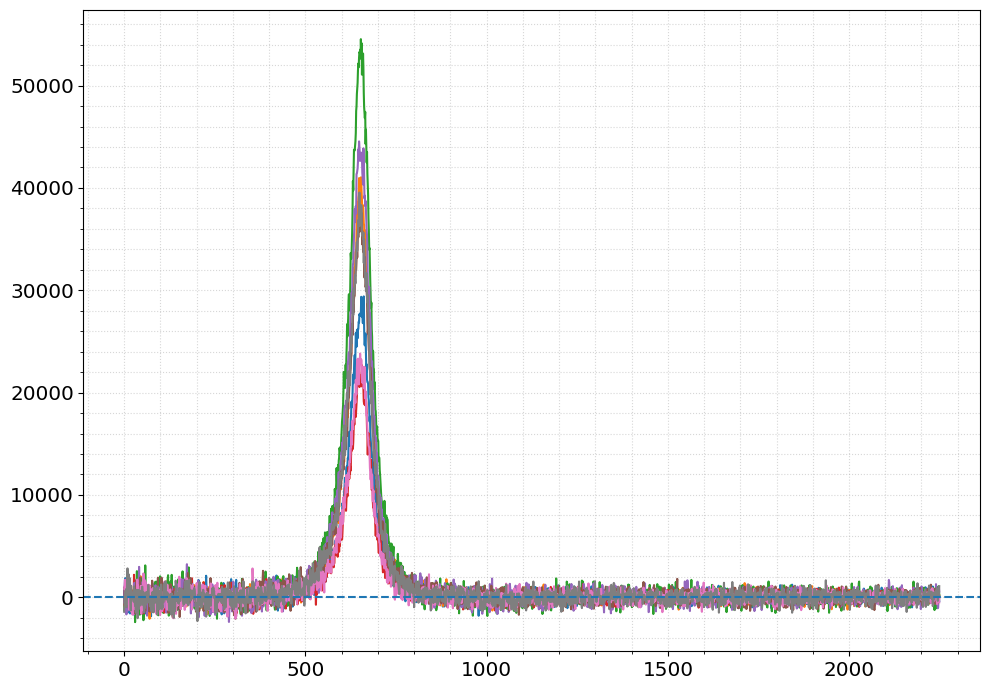

In [24]:
print(len(bgsub_D))
print(len(bgsub_D[0]))
print(len(bgsub_D[0][0]))

%matplotlib inline
for ch in range(0,8):
    ch = ch
    r  = 330
    plt.plot(bgsub_D[r][ch])
plt.axhline(y=0, ls = '--')

[   0.003112    0.015263    0.975555 1428.514585]
[[  0.000002  -0.000001  -0.        -0.025808]
 [ -0.000001   0.         0.         0.014404]
 [ -0.         0.         0.         0.000082]
 [ -0.025808   0.014404   0.000082 523.577372]]
28678.860346323818
3580.7550489451014
183151.2515233722
459092.10560253885
14239.492670987747
[10752.988513 11419.323472 12209.621053 12172.531481 11572.027629
 12725.730326 12702.430056 12577.015184 14737.762492 14614.221149]


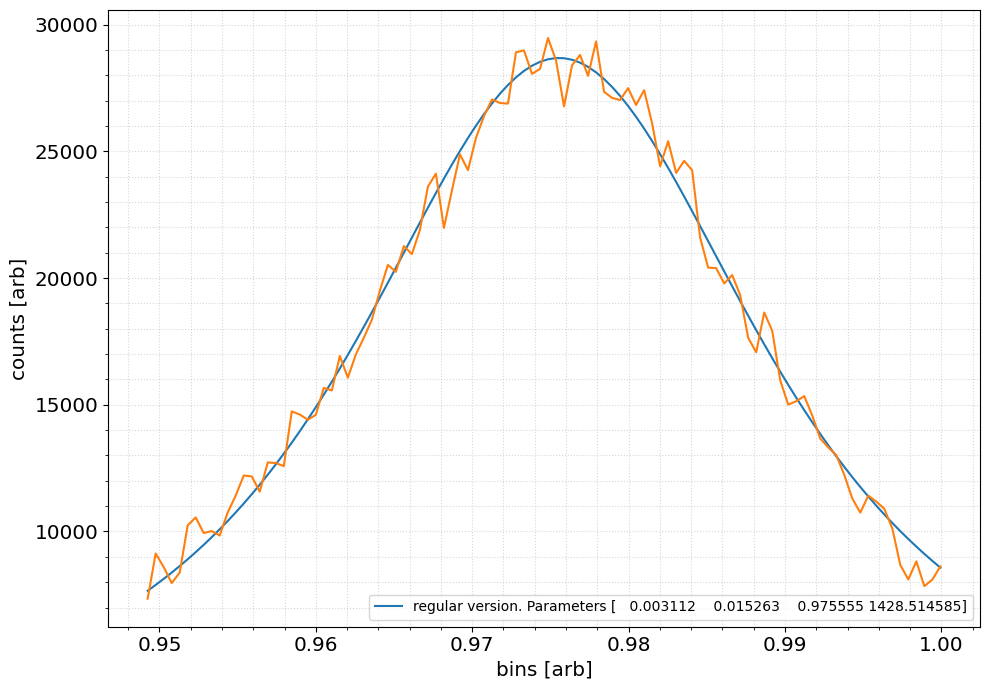

In [25]:
## look at fitting manually
# %matplotlib inline
plt.figure()

r = 90
ch = 3

res_region_beg = 3850
res_region_end = 3950
res_reg = [res_region_beg,res_region_end]
newresstart = res_reg[0]-bg_reg1[0]
newresend   = (res_reg[1]-res_reg[0])+newresstart

xdata = xs[res_reg[0]:res_reg[1]]
# ydata = bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata = bgsub_U[r][ch][newresstart:newresend]
ydata_np = bgsub_U[r][ch][newresstart:newresend]

def voigt2(x, sig, gam, xshift, amp):
#     xshift=1.9678
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

# popt, pcov = curve_fit(voigt2, xdata, ydata)
# popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,0.79,-np.inf], [np.inf,np.inf,0.85, np.inf]))
# popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))
# popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.005,0.005,0.975,100], bounds = ([0.0,0.0,0.9,-np.inf], [np.inf,np.inf,1.1, np.inf]))
popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.005,0.014,0.975,1000], bounds = ([0.0005,0.005,0.9,-np.inf], [0.020,0.25,1.1, np.inf]))

np.set_printoptions(suppress=True, precision=6)
print(popt)
print(pcov)

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
# fitted_curve_np = voigt2(xdata, popt_np[0],popt_np[1],popt_np[2],popt_np[3],)

print(max(fitted_curve))
print((popt[3])*np.sqrt(2*np.pi))
print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
print((popt[3])/(popt[0]))
print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

print(ydata[10:20])## this plots the other res too
ydata2 =  bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
xtest = xs[bg_reg1[1]:bg_reg2[0]]

plt.plot(xdata,fitted_curve, label = f'regular version. Parameters {popt}')
# plt.plot(fitted_curve_np, label = 'np version', ls='--')

# plt.plot(xs, ON_bgsub[1][0])
plt.legend()
plt.plot(xdata,ydata)
plt.ylabel('counts [arb]',fontsize = 'x-large')
plt.xlabel('bins [arb]',fontsize = 'x-large')
plt.show()

resonance at  2.987660800700151 eV


ValueError: x and y must have same first dimension, but have shapes (2100,) and (2250,)

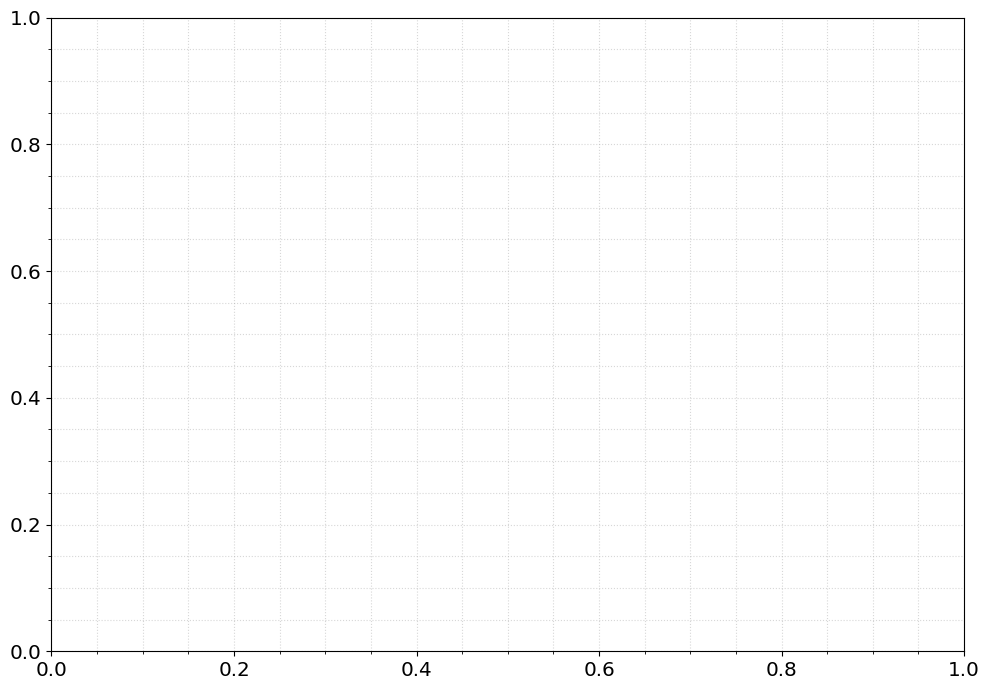

In [26]:
## same as above replotted for other res, thesis
%matplotlib inline
plt.figure()
tofres = 0.975
fpl = 23.31
print('resonance at ', tof_to_eV(tofres, fpl, 0), 'eV')

ydata2 =  bgsub_U[r][ch]
# ydata2 =  bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
xdata2 = xs[fullx]
plt.plot(xdata2, ydata2, label='BG subtracted region', ls='none', marker='o', ms = 4.0)
plt.plot(xdata,ydata,label='Selected resonance region', ls='none', marker='D', ms = 4.5)

plt.plot(xdata, fitted_curve, label = 'Voigt fit to resonance', ls = '--', lw=3.0)
# plt.plot(xdata, fitted_curve_np, label = 'np version', ls='--')
# ydata = bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

plt.title(rf'La - Resonance Region Voigt fit', fontsize = 'xx-large')
# plt.xticks(np.arange(-1.0,4.0, 0.5),fontsize = 'large')
plt.grid(True, which='both', alpha = 0.5, ls = ':')
plt.minorticks_on()
plt.xticks(fontsize = 'x-large')
plt.yticks(fontsize = 'x-large')
plt.ylabel('counts [arb]',fontsize = 'x-large')
plt.xlabel('tof [ms]',fontsize = 'x-large')
plt.legend(fontsize = 'medium')
plt.show()

# automate voigt

In [27]:
# xs_cut = [xs] # let's just match the previous notation
# xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6  ## just change all xs to ms and one array
# # print(xs_cut[0])
# print(len(xdata))
# # print(xdata[400])

In [34]:
################################################### try w AI

def voigt2(x, sig, gam, xshift, amp):
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

# Define resonance region (global bin indices, keep general)
res_region_beg = 3850
res_region_end = 3950
res_reg = [res_region_beg, res_region_end]
# Convert to local indices within bg-sub window
res_reg_local = [res_reg[0] - bg_reg1[0], res_reg[1] - bg_reg1[0]]

if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)


def voigt_fitting_4(xs_win, ys_win, res_reg_local):
    # select resonance region
    xdata = xs_win[res_reg_local[0]:res_reg_local[1]]
    ydata = ys_win[res_reg_local[0]:res_reg_local[1]]
    # curve_fit
    popt, pcov = curve_fit(voigt2, xdata, ydata, p0=[0.0044, 0.0145, 0.975, 1000],
        bounds=([0.0001, 0.007, 0.973, 0], [0.01, 0.02, 0.977, np.inf]))
    # popt, pcov = curve_fit(voigt2, xdata, ydata, p0=[0.005, 0.014, 0.97, 1000])
    fitted_curve = voigt2(xdata, *popt)
    fit_params = popt
    fit_errs = np.diagonal(pcov)
    return fitted_curve, [fit_params, fit_errs]

######################################### new
res_size = res_reg[1]-res_reg[0] 
voigt_D = np.zeros((numruns_tot_D, num_fittingchs,res_size), dtype = np.float64) ## num runs, channels, range of voigt
voigt_U = np.zeros((numruns_tot_U, num_fittingchs,res_size), dtype = np.float64) ## num runs, channels, range of voigt

v_params_D = np.zeros((numruns_tot_D, num_fittingchs,2,4), dtype = np.float64) ## channels, sequences,[params, param_errs], [sigma, gamma, shift, amp thing]
v_params_U = np.zeros((numruns_tot_U, num_fittingchs,2,4), dtype = np.float64)

addtimes = 0
checkpoints = 5
step = max(1, len(all_D) // checkpoints)

for r in range(0, len(bgsub_D)): ## for every run    
    start = time.time()
    for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
        if channels_D[ch] == 'ch_24':
            emessage = ('v fit does not work for 6Li yet')
            logger.error('run '+run_num + emessage)
            raise Exception(emessage)
        try:
            voigt_D[r, ch], v_params_D[r, ch] = voigt_fitting_4(xs_win, bgsub_D[r, ch], res_reg_local)
            voigt_U[r, ch], v_params_U[r, ch] = voigt_fitting_4(xs_win, bgsub_U[r, ch], res_reg_local)
        except Exception as e:
            print('run ', r, 'chan ', ch)
            print("An error occurred:", e)
    end = time.time()
    addtimes = addtimes+(end-start)
    if (r + 1) % step == 0 or r == len(all_D) - 1:
        print(f'Run {r+1}/{len(all_D)}, took {addtimes:.2f} s for last {step} runs')
        addtimes = 0


Run 129/648, took 13.33 s for last 129 runs
Run 258/648, took 13.07 s for last 129 runs
Run 387/648, took 13.17 s for last 129 runs
Run 516/648, took 13.21 s for last 129 runs
Run 645/648, took 13.43 s for last 129 runs
Run 648/648, took 0.35 s for last 129 runs


In [35]:
plt.rcParams.update({
    'legend.fontsize': 'large',
    'grid.alpha': '0.65',
})
# %matplotlib qt
print('updated rcparam')

updated rcparam


0.004290385739978032
0.001067279339299637
0.31557345390319824 sec


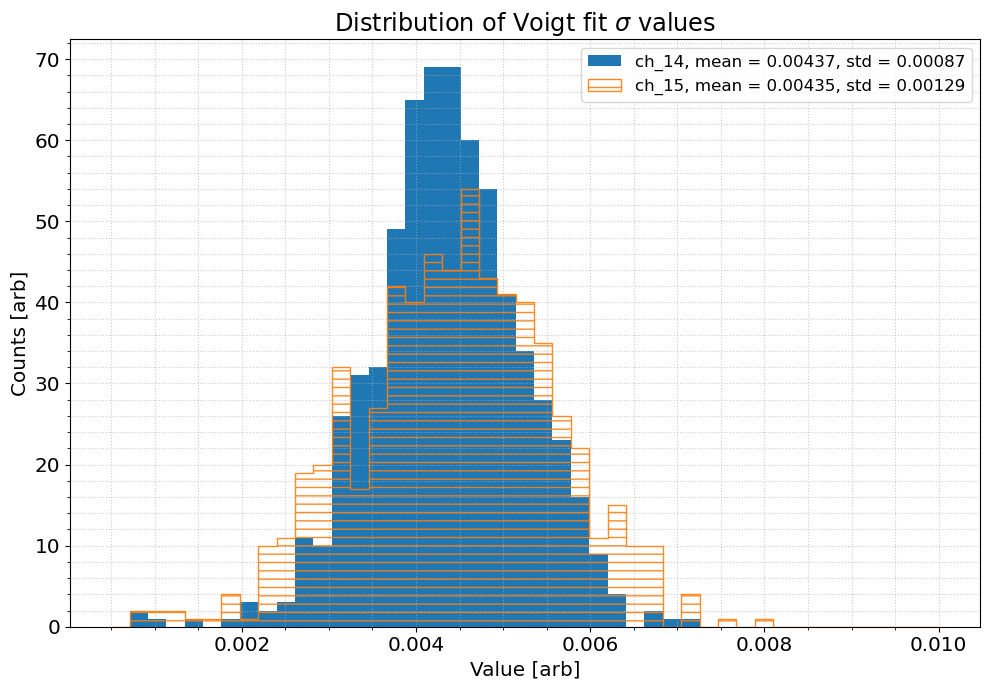

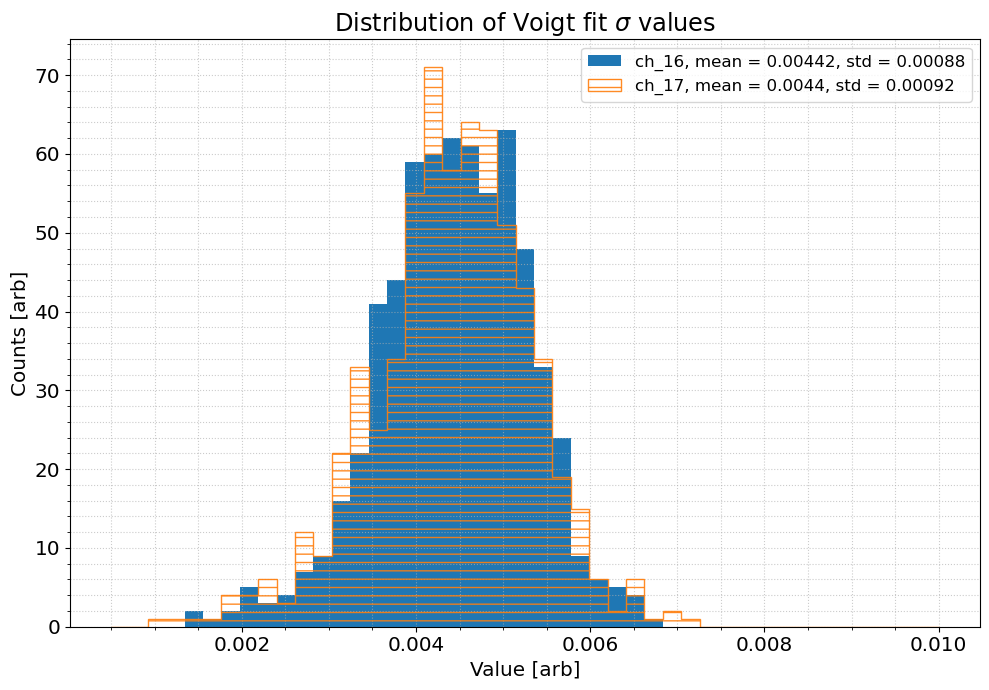

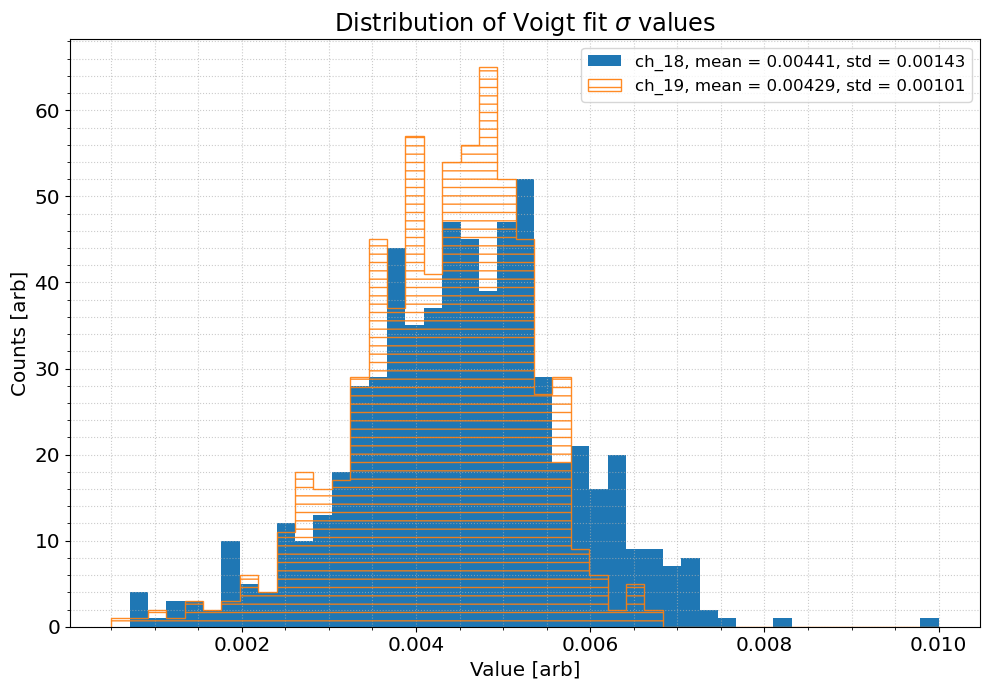

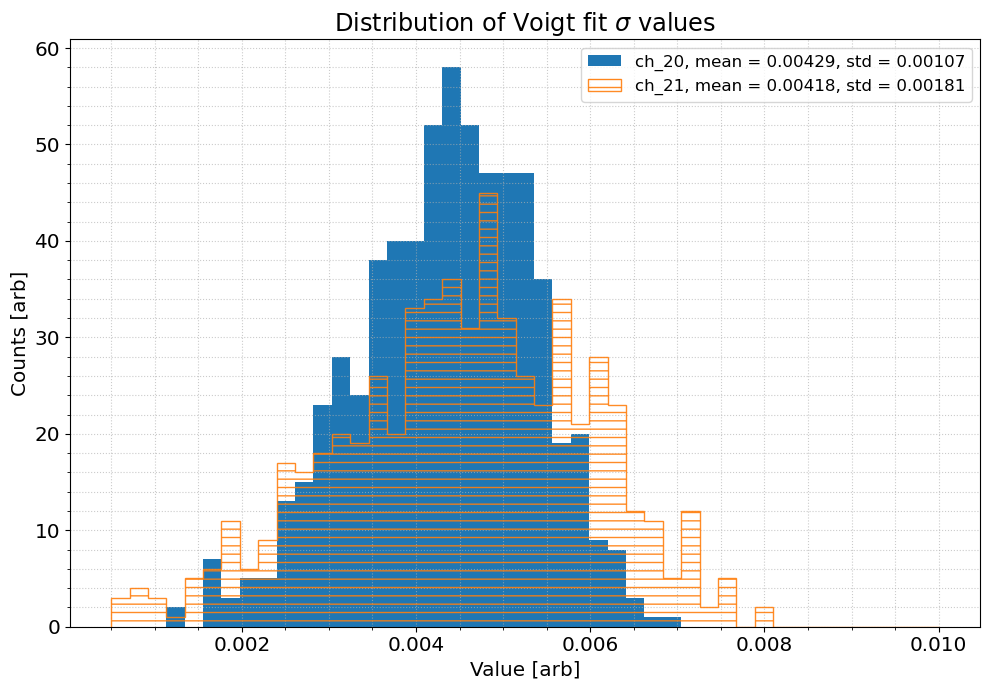

In [36]:
## sigma
## all runs, select channel, 0th array [param values, not erros], and parameter p
%matplotlib inline
ran = [0.0005,0.010]
b = 100
p = 0
key = 'up'
if key == 'up':
    vdata = v_params_U
    chleg = channels_U
if key == 'dn':
    vdata = v_params_D
    chleg = channels_D

ch = 2
fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\sigma$ values')
# plt.title(rf'Distribution of Voigt fit $\sigma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,0]),5)
std = np.round(np.std(vdata[:,ch,0,0]),5)
mean2 = np.round(np.average(vdata[:,ch+1,0,0]),5)
std2 = np.round(np.std(vdata[:,ch+1,0,0]),5)
plt.hist(vdata[:,ch,0,0], bins =45, range = ran,  label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,0], bins =45, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\sigma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\sigma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,0]),5)
std = np.round(np.std(vdata[:,ch,0,0]),5)
mean2 = np.round(np.average(vdata[:,ch+1,0,0]),5)
std2 = np.round(np.std(vdata[:,ch+1,0,0]),5)
plt.hist(vdata[:,ch,0,0], bins =45, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,0], bins =45, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\sigma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\sigma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,0]),5)
std = np.round(np.std(vdata[:,ch,0,0]),5)
mean2 = np.round(np.average(vdata[:,ch+1,0,0]),5)
std2 = np.round(np.std(vdata[:,ch+1,0,0]),5)
plt.hist(vdata[:,ch,0,0], bins =45, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,0], bins =45, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\sigma$ values')
ch=ch+2
# plt.title(rf'Distribution of Voigt fit $\sigma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,0]),5)
std = np.round(np.std(vdata[:,ch,0,0]),5)
mean2 = np.round(np.average(vdata[:,ch+1,0,0]),5)
std2 = np.round(np.std(vdata[:,ch+1,0,0]),5)
plt.hist(vdata[:,ch,0,0], bins =45, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,0], bins =45, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value

print(np.average(vdata[:,ch,0,0]))
print(np.std(vdata[:,ch,0,0]))

plt.legend()
# plt.show()

# print(ys_bgsub)

end = time.time()
print(end-start, 'sec')

In [37]:
# print(vdata[:,9,0,0])

0.00492700693661761
0.0011262783938223665


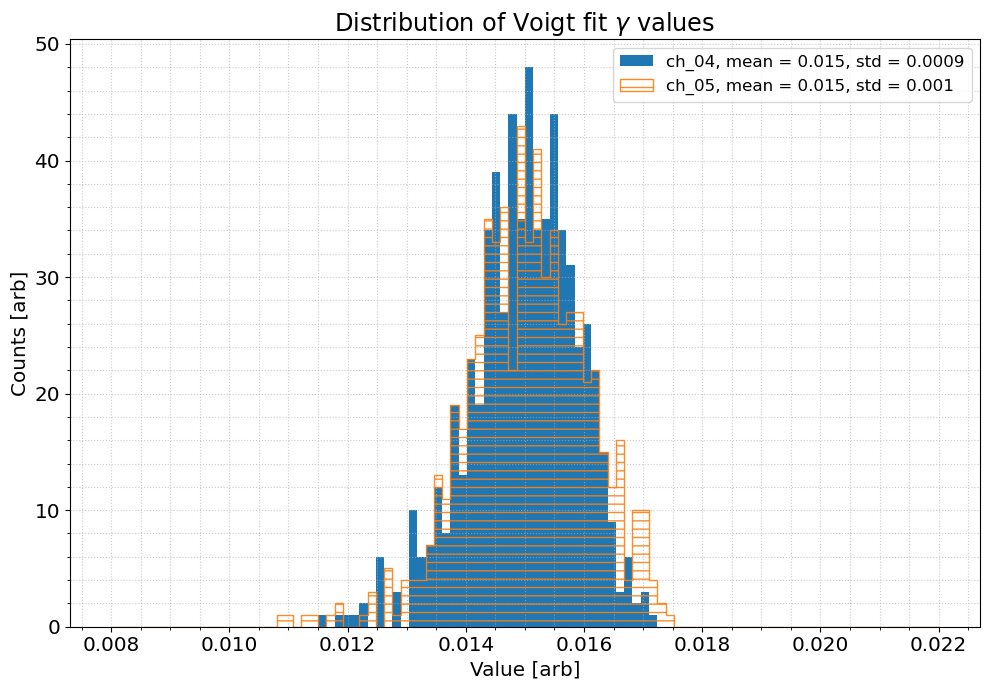

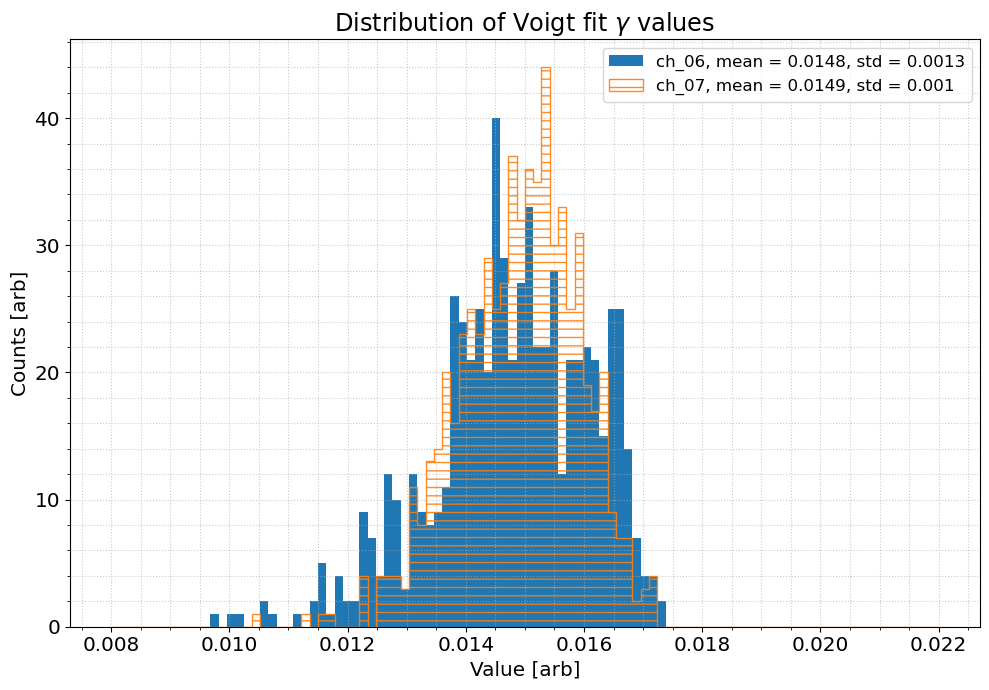

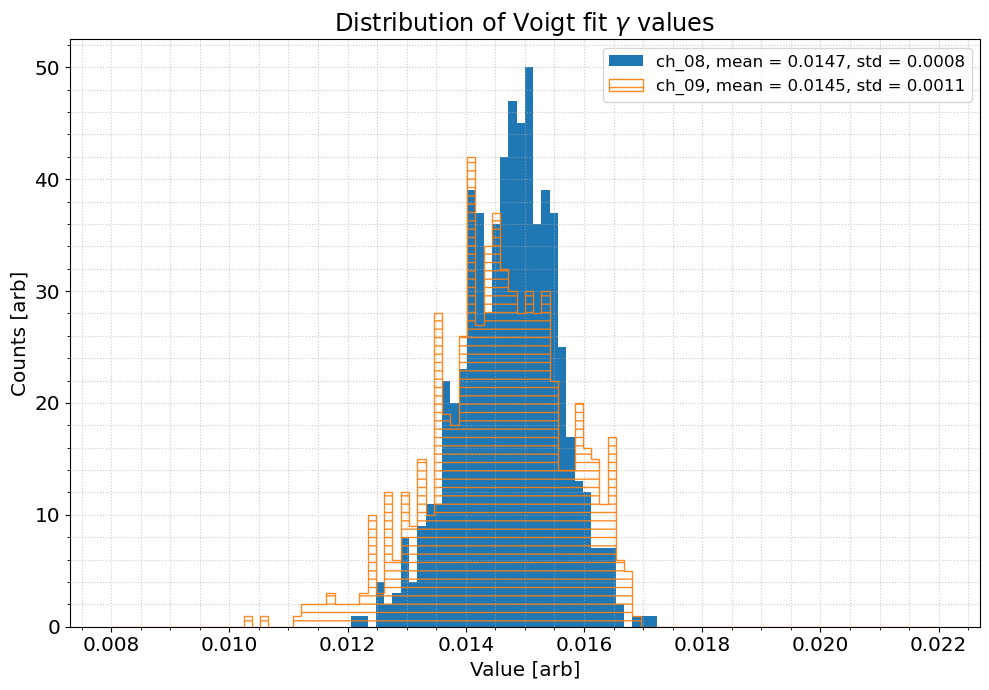

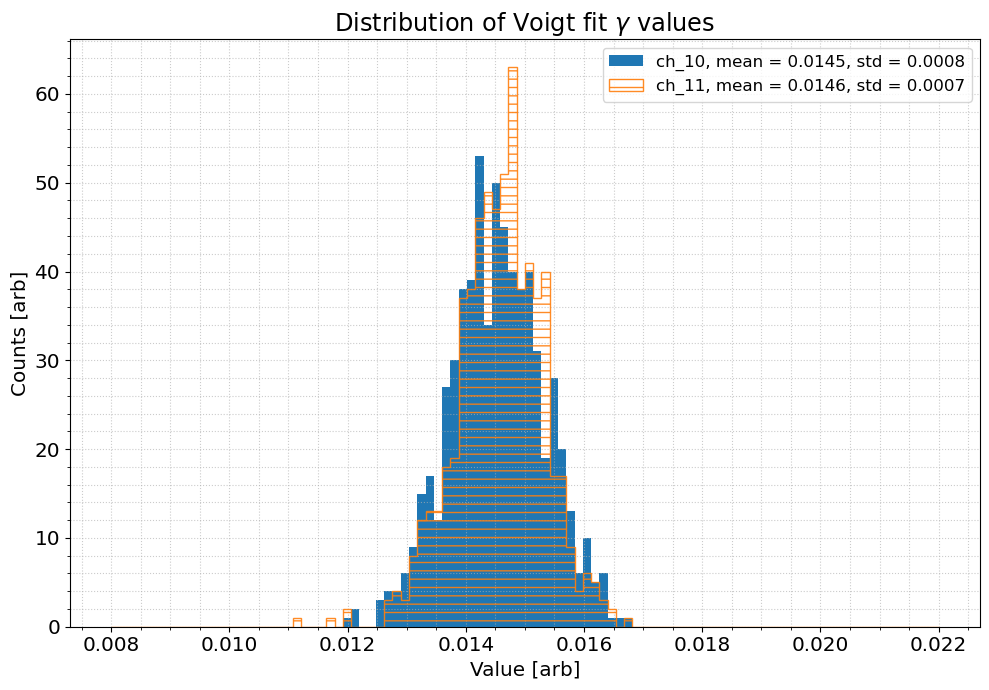

64.09647393226624 sec


In [42]:
## new gamma
 ## all runs, select channel, 0th array [param values, not erros], and parameter p
%matplotlib inline
ran = [0.008,0.022]
b = 100
p = 1
key = 'dn'
if key == 'up':
    vdata = v_params_U
    chleg = channels_U
if key == 'dn':
    vdata = v_params_D
    chleg = channels_D

ch = 4
fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\gamma$ values')
mean = np.round(np.average(vdata[:,ch,0,p]),4) 
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran,  label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()
# plt.xticks(np.arange(-1.0,4.0, 0.5),fontsize = 'large')
# plt.grid(True, which='both', alpha = 0.5, ls = ':')
# plt.minorticks_on()
# plt.xticks(fontsize = 'x-large')
# plt.yticks(fontsize = 'x-large')

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\gamma$ values')
ch=ch+2
plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\gamma$ values')
ch=ch+2
plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

fig, ax = plt.subplots()
ax.set(xlabel='Value [arb]', ylabel='Counts [arb]',title=rf'Distribution of Voigt fit $\gamma$ values')
ch=ch+2
plt.title(rf'Distribution of Voigt fit $\gamma$ values', fontsize = 'xx-large')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

print(np.average(vdata[:,ch,0,0]))
print(np.std(vdata[:,ch,0,0]))


plt.show()

# print(ys_bgsub)

end = time.time()
print(end-start, 'sec')

0.004719924161756268
0.0019910973663421843


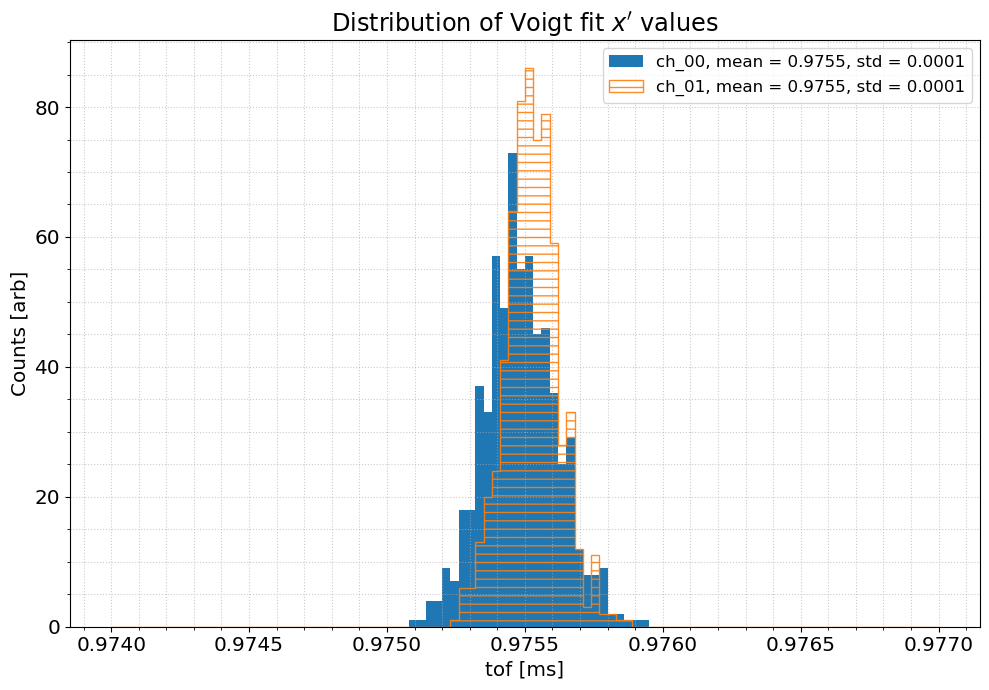

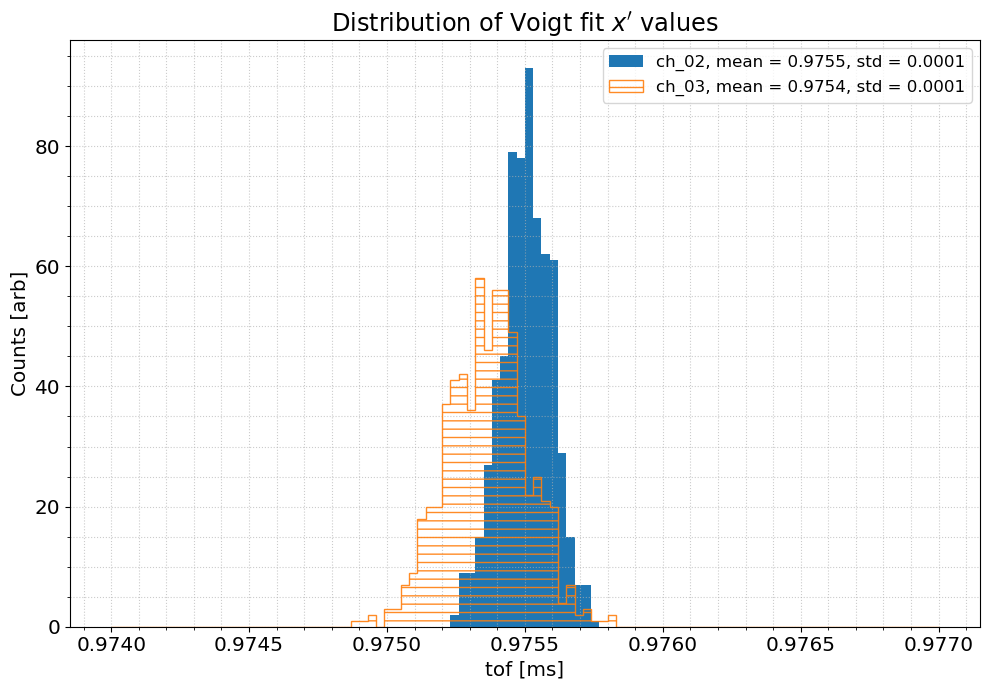

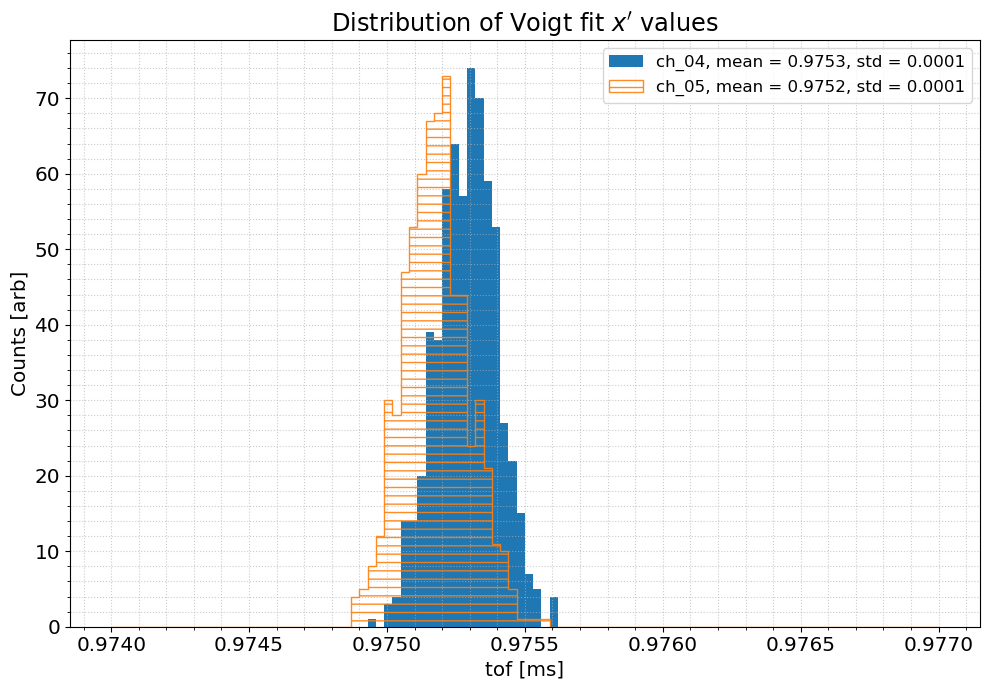

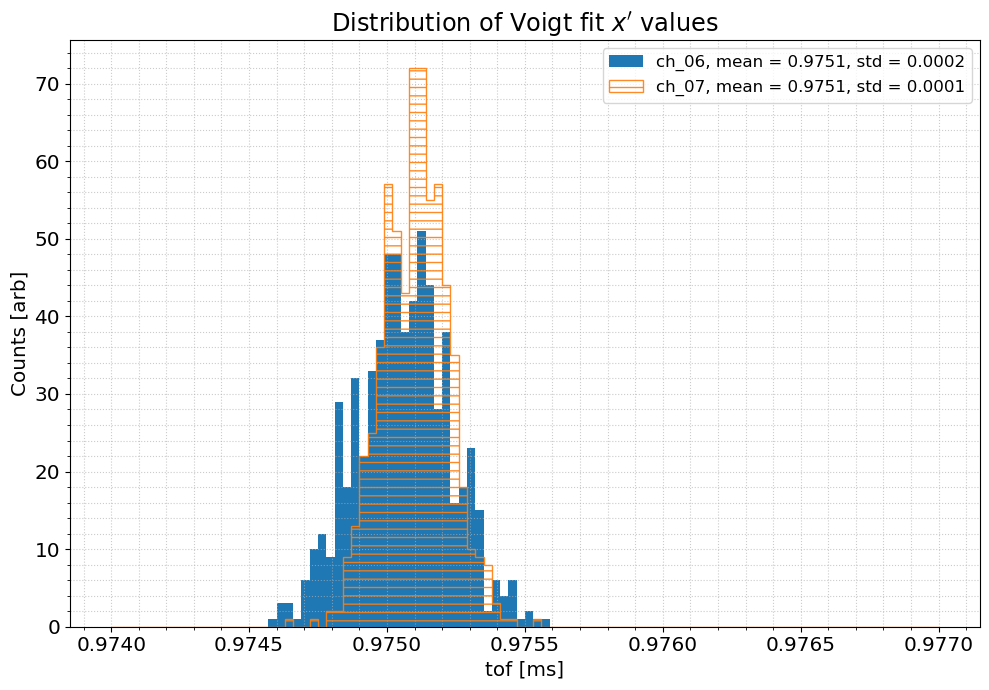

66.19440865516663 sec


In [43]:
## new xshift
## all runs, select channel, 0th array [param values, not erros], and parameter p
%matplotlib inline
ran = [0.974,0.977]
b = 100
p = 2
key = 'dn'
if key == 'up':
    vdata = v_params_U
    chleg = channels_U
if key == 'dn':
    vdata = v_params_D
    chleg = channels_D

ch = 0
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title=r'Distribution of Voigt fit $x^\prime$ values')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran,  label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

ch=ch+2
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title=r'Distribution of Voigt fit $x^\prime$ values')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()


ch=ch+2
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title=r'Distribution of Voigt fit $x^\prime$ values')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

ch=ch+2
fig, ax = plt.subplots()
ax.set(xlabel='tof [ms]', ylabel='Counts [arb]',title=r'Distribution of Voigt fit $x^\prime$ values')
mean = np.round(np.average(vdata[:,ch,0,p]),4)
std = np.round(np.std(vdata[:,ch,0,p]),4)
mean2 = np.round(np.average(vdata[:,ch+1,0,p]),4)
std2 = np.round(np.std(vdata[:,ch+1,0,p]),4)
plt.hist(vdata[:,ch,0,p], bins =b, range = ran, label = chleg[ch]+rf', mean = {mean}, std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(vdata[:,ch+1,0,p], bins =b, range = ran, alpha =0.9, hatch='--',histtype='step', label = chleg[ch+1]+rf', mean = {mean2}, std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.legend()

print(np.average(vdata[:,ch,0,0]))
print(np.std(vdata[:,ch,0,0]))

plt.show()

# print(ys_bgsub)

end = time.time()
print(end-start, 'sec')

In [44]:
print(v_params_U[:,:,0,2])
print(v_params_D.shape)
det = 0
print(f'avg dif U - D: {np.mean(v_params_U[:,:,0,2])-np.mean(v_params_D[:,:,0,2])}')

for i in range(12):
    uptime = np.mean(v_params_U[:,i,0,2])
    dntime = np.mean(v_params_D[:,i,0,2])
    print(f'upstream res loc: {np.round(uptime,5)}, downstream: {np.round(dntime,5)}')
    print(f'up - down = {(uptime-dntime)}')
    print()

[[0.975407 0.975665 0.975701 ... 0.975309 0.975342 0.975634]
 [0.975462 0.975597 0.975697 ... 0.975106 0.975312 0.975453]
 [0.975226 0.975557 0.975596 ... 0.975387 0.975429 0.975472]
 ...
 [0.975302 0.975577 0.975593 ... 0.975256 0.975392 0.975441]
 [0.975324 0.975612 0.975669 ... 0.975128 0.975424 0.975332]
 [0.975813 0.975718 0.975631 ... 0.975248 0.975098 0.975482]]
(648, 12, 2, 4)
avg dif U - D: 0.0001546534537971711
upstream res loc: 0.97551, downstream: 0.97548
up - down = 2.335665958796973e-05

upstream res loc: 0.97562, downstream: 0.97553
up - down = 9.24030438491652e-05

upstream res loc: 0.97565, downstream: 0.9755
up - down = 0.00015054252998092377

upstream res loc: 0.97557, downstream: 0.97536
up - down = 0.00020876714276918396

upstream res loc: 0.97553, downstream: 0.97529
up - down = 0.0002378616753240248

upstream res loc: 0.97546, downstream: 0.97518
up - down = 0.00028311726504692825

upstream res loc: 0.97533, downstream: 0.97506
up - down = 0.00027545953140328816


In [45]:
ch =8
print(channels_U[ch])
p = 0
print(len((v_params_U[:,ch,0,0])))
print(np.round(np.average(v_params_U[:,ch,0,p]),5))
rounded_arr_2dp = np.round(v_params_U[:,ch,0,p], decimals=4)
print(len(rounded_arr_2dp))
print((v_params_U[:,ch,0,p][0:10]))
print((rounded_arr_2dp[0:10]))
mode_D = st.mode(v_params_U[:,ch,1,p], keepdims = False)
print(mode_D)
mode_D = st.mode(rounded_arr_2dp, keepdims = False)
print(mode_D)

ch_20
648
0.00429
648
[0.003164 0.004643 0.005258 0.006409 0.004528 0.003819 0.006197 0.004887
 0.002554 0.006249]
[0.0032 0.0046 0.0053 0.0064 0.0045 0.0038 0.0062 0.0049 0.0026 0.0062]
ModeResult(mode=np.float64(5.024951430612802e-07), count=np.int64(1))
ModeResult(mode=np.float64(0.0045), count=np.int64(34))


In [46]:
## now loop through and record the mean, mode, and std of each parameter
start = time.time()
num_v_params = len(v_params_D[0][0][0])-1 ## -1 because we exclude the 'amplitude' parameter that will be left varying
v_params_mean_D = np.zeros((num_fittingchs,3,num_v_params), dtype = np.float64) ## num channels, [p_mean,p_mode,std], num parameters
v_params_mean_U = np.zeros((num_fittingchs,3,num_v_params), dtype = np.float64) ## num channels, [p_mean,p_mode,std], num parameters
print(len(v_params_mean_D))
print(len(v_params_mean_D[0]))
print(len(v_params_mean_D[0][0]))

for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
    if channels_D[ch] == 'ch_24':
        emessage = ('bg_ fit does not work for 6Li yet')
        logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    for param in range(0, num_v_params):
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
        mean_D = np.average(v_params_D[:,ch,0,param]) ## just easier to read # 0 indicates the parameter mean
        mean_U = np.average(v_params_U[:,ch,0,param])
        std_D = np.std(v_params_D[:,ch,0,param]) ## just easier to read # 2 indicates the parameter std as
        std_U = np.std(v_params_U[:,ch,0,param])
        rounded_arr_D = np.round(v_params_D[:,ch,0,param], decimals=4)  ##just picked decimal 4 arbitrarily. But might work.
        rounded_arr_U = np.round(v_params_U[:,ch,0,param], decimals=4)
        mode_D = st.mode(rounded_arr_D, keepdims = False) ## just easier to read # 1 indicates the parameter mode
        mode_U = st.mode(rounded_arr_U, keepdims = False)
        v_params_mean_D[ch][0][param] = mean_D
        v_params_mean_D[ch][1][param] = mode_D[0]
        v_params_mean_D[ch][2][param] = std_D
        v_params_mean_U[ch][0][param] = mean_U
        v_params_mean_U[ch][1][param] = mode_U[0]
        v_params_mean_U[ch][2][param] = std_U

end = time.time()
print('time ', (end-start))

12
3
3
time  0.024735689163208008


In [47]:
## checking mean/mode/std outputs

# for ch in range(0,12):
# #     ch = 10
#     p=0
#     mean = np.average(v_params_D[:,ch,0,p])
#     std = np.std(v_params_D[:,ch,0,p])
#     mode_D = st.mode(np.round(v_params_D[:,ch,0,p], decimals=4), keepdims = False)
#     print(mean)
#     print(mode_D)
#     print(std)
#     print()
#     print(v_params_mean_D[ch][0][p])
#     print(v_params_mean_D[ch][1][p])
#     print(v_params_mean_D[ch][2][p])
#     print('--')

In [48]:
print(len(v_params_mean_D))
print(len(v_params_mean_D[0]))
print(len(v_params_mean_D[0][0]))

# print(v_params_mean_D[9:])
# print('----------------')
# print(v_params_mean_U[0:3])
# print()
v_params_mean_all = np.vstack((v_params_mean_D,v_params_mean_U))
print(len(v_params_mean_all))
print(len(v_params_mean_all[0]))
print(len(v_params_mean_all[0][0]))
# print(v_params_mean_all[9:])

12
3
3
24
3
3


In [50]:
# checking

for ch in range(0,12):
#     ch = 10
    p=2
#     mean = np.average(v_params_D[:,ch,0,p])
#     std = np.std(v_params_D[:,ch,0,p])
#     mode_D = st.mode(np.round(v_params_D[:,ch,0,p], decimals=4), keepdims = False)
#     print(mean)
#     print(mode_D)
#     print(std)
    print()
    print(v_params_mean_U[ch][0][p])
    print(v_params_mean_U[ch][1][p])
    print(v_params_mean_U[ch][2][p])
    print()
    print(v_params_mean_all[ch+12][0][p])
    print(v_params_mean_all[ch+12][1][p])
    print(v_params_mean_all[ch+12][2][p])
    print('--')


0.9755068824240921
0.9755
0.0001330565219454471

0.9755068824240921
0.9755
0.0001330565219454471
--

0.9756178200649533
0.9756
7.873539229006108e-05

0.9756178200649533
0.9756
7.873539229006108e-05
--

0.9756538684015764
0.9757
8.029244410107644e-05

0.9756538684015764
0.9757
8.029244410107644e-05
--

0.9755712267384717
0.9756
0.00012257131333611896

0.9755712267384717
0.9756
0.00012257131333611896
--

0.9755277865671698
0.9755
7.944201925175182e-05

0.9755277865671698
0.9755
7.944201925175182e-05
--

0.9754597153419639
0.9755
8.387371179541334e-05

0.9754597153419639
0.9755
8.387371179541334e-05
--

0.975333903636339
0.9753
0.0001269555633607277

0.975333903636339
0.9753
0.0001269555633607277
--

0.9753633932928079
0.9754
9.373964882882113e-05

0.9753633932928079
0.9754
9.373964882882113e-05
--

0.9753422433090309
0.9753
9.418051599234062e-05

0.9753422433090309
0.9753
9.418051599234062e-05
--

0.9752614358676438
0.9752
0.00014443227559912068

0.9752614358676438
0.9752
0.000144432275

In [38]:
print(channels_all)
print(len(v_params_mean_all))
# print((v_params_mean_all[0][0]))
print(v_params_mean_all[-1,:,2])

['ch_00' 'ch_01' 'ch_02' 'ch_03' 'ch_04' 'ch_05' 'ch_06' 'ch_07' 'ch_08'
 'ch_09' 'ch_10' 'ch_11' 'ch_12' 'ch_13' 'ch_14' 'ch_15' 'ch_16' 'ch_17'
 'ch_18' 'ch_19' 'ch_20' 'ch_21' 'ch_22' 'ch_23' 'ch_24']
24
[1.96724255e+00 1.96730000e+00 6.94208874e-04]


In [53]:
print(bg_reg1, bg_reg2, res_reg)

[3250, 3650] [4100, 5500] [3850, 3950]


In [51]:
## save out vfit params to hdf5

# bg_reg1_bef = [bg_region1_beg,bg_region1_end]
# bg_reg2_aft = [bg_region2_beg,bg_region2_end]

with h5py.File(vconstantsavename+'.h5', 'w') as hdf5_file:
    hdf5_file.attrs['bg_reg_bef'] = bg_reg1 ## adding the puck information
    hdf5_file.attrs['bg_reg_aft'] = bg_reg2 ## adding the puck information
    hdf5_file.attrs['res_reg'] = res_reg ## will be empty if puck is not in (usually)
#     hdf5_file.attrs['num_pulses'] = numRuns ## some runs do not have 5000 pulses! Usually the ones at the end
#     hdf5_file.attrs['sequences'] = len(sequence[0])
    for ch in range(0,len(v_params_mean_all)): ## change this to length of asymms!
        Ch_grp = hdf5_file.create_group(channels_all[ch])
        Ch_grp.attrs['sigma_[mean,mode,std]']   = v_params_mean_all[ch,:,0]
        Ch_grp.attrs['gamma_[mean,mode,std]']   = v_params_mean_all[ch,:,1]
        Ch_grp.attrs['res_loc_[mean,mode,std]'] = v_params_mean_all[ch,:,2]

#### troubleshooting bimodal res location...

In [32]:
import scipy as sp

In [33]:
print(res_reg)
print(bgsub_D.shape)

[3800, 4000]
(648, 12, 2250)


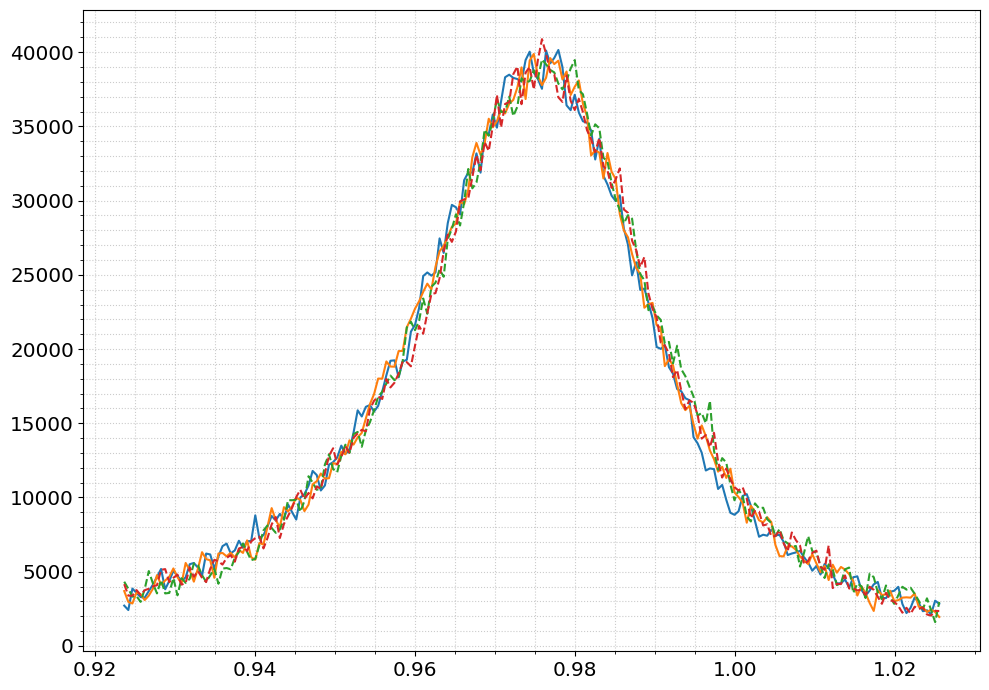

In [130]:
ch = 1
r = 518
r2 = 519
r3 = 515
r4 = 520

res_region_beg = 3800
res_region_end = 4000
res_reg = [res_region_beg,res_region_end]
newresstart = res_reg[0]-bg_reg1[0]
newresend   = (res_reg[1]-res_reg[0])+newresstart

xdata = xs[res_reg[0]:res_reg[1]]
# ydata = bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata = bgsub_D[r][ch][newresstart:newresend]
ydata2 =  bgsub_D[r2][ch][newresstart:newresend]
ydata3 =  bgsub_D[r3][ch][newresstart:newresend]
ydata4 =  bgsub_D[r4][ch][newresstart:newresend]

# ydata2 =  bgsub_D[r2][ch][newresstart:newresend]
# # ydata2 =  bgsub_U[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
# xdata2 = xs[fullx]
# plt.plot(xdata2, ydata2, label='BG subtracted region', ls='none', marker='o', ms = 4.0)
plt.plot(xdata,ydata,label='Selected resonance region', ls='-')
# plt.plot(xdata, voigt_D[r,ch], label = 'Voigt fit to resonance', ls = '-', lw=3.0)

plt.plot(xdata,ydata2,label='Selected resonance region', ls='-')
# plt.plot(xdata, voigt_D[r2,ch], label = 'Voigt fit to resonance', ls = '-', lw=3.0)

plt.plot(xdata,ydata3,label='Selected resonance region', ls='--')
# plt.plot(xdata, voigt_D[r3,ch], label = 'Voigt fit to resonance', ls = '-', lw=3.0)

plt.plot(xdata,ydata4,label='Selected resonance region', ls='--')


In [37]:
%matplotlib qt
ch = 1
r = 2
r2 = 0

print((len(v_params_D[:,ch,0,2])))
print((np.mean(v_params_D[:,ch,0,2][0:100])))
print((np.mean(v_params_D[:,ch,0,2][500:-1])))
print(np.where(v_params_D[:,ch,0,2]<0.9749)[0:20])
print(np.where(v_params_D[:,ch,0,2]>0.9751)[0:20])

# xdata = xs[res_reg[0]:res_reg[1]]
# plt.plot(xdata, bgsub_D[r,ch,res_reg[0]:res_reg[1]])
# plt.plot(xdata, bgsub_D[r2,ch][res_reg[0]:res_reg[1]])
# plt.plot(xdata, voigt_D[r,ch])
# plt.plot(xdata, voigt_D[r2,ch])

648
0.9750508601302234
0.9750374186619066
(array([  2,   3,   7,  13,  14,  15,  19,  20,  21,  23,  24,  28,  29,
        32,  33,  34,  35,  36,  39,  40,  41,  43,  45,  52,  53,  54,
        55,  57,  59,  61,  62,  63,  64,  65,  66,  67,  70,  72,  80,
        85,  87,  89,  92,  93,  95,  99, 102, 104, 110, 112, 115, 116,
       117, 119, 121, 122, 123, 124, 126, 129, 130, 132, 138, 140, 141,
       142, 143, 145, 149, 156, 159, 161, 166, 175, 186, 191, 193, 195,
       197, 202, 203, 205, 207, 211, 214, 216, 219, 220, 222, 225, 229,
       230, 231, 233, 235, 238, 241, 246, 247, 253, 257, 258, 259, 262,
       263, 267, 269, 270, 272, 273, 277, 280, 282, 284, 290, 291, 297,
       298, 301, 306, 307, 308, 311, 315, 319, 323, 325, 326, 328, 329,
       331, 334, 335, 337, 338, 339, 341, 343, 344, 347, 349, 351, 353,
       354, 357, 358, 361, 362, 363, 365, 366, 374, 375, 376, 377, 378,
       384, 388, 391, 392, 395, 398, 400, 401, 402, 403, 409, 410, 414,
       419, 422, 427,

In [42]:
ch = 1
m1_1= bgsub_D[2,ch]
m1_2=bgsub_D[365,ch]
m1_3 = bgsub_D[641,ch]
m1 = [m1_1,m1_2,m1_3]

m2_1= bgsub_D[1,ch]
m2_2=bgsub_D[359,ch]
m2_3 = bgsub_D[644,ch]
m2 = [m2_1,m2_2,m2_3]

ch1_subset = np.array([m1,m2])
print(ch1_subset.shape)

%matplotlib qt
# for i in range(3):
#     plt.plot(ch1_subset[0][i], ls='-')
#     mn_1 = np.mean(m1)
#     mn_2 = np.mean(m2)
#     plt.plot(ch1_subset[1][i], ls='--')
mn_1 = np.mean(m1, axis =0)
mn_2 = np.mean(m2, axis =0)
plt.plot(mn_1)
plt.plot(mn_2)


(2, 3, 2250)


In [189]:
## compare mean to some pulses
ch = 1
r = 2
mean_spec = np.mean(bgsub_D[:,ch], axis=0)  # depends on shape
# %matplotlib qt
# plt.plot(mean_spec)
# plt.plot(bgsub_D[r][ch])
# plt.plot(bgsub_D[r+10][ch])
# plt.plot(bgsub_D[r+20][ch])
# plt.plot(bgsub_D[r+30][ch])
# plt.title('Average spectrum')
print(mean_spec.shape)
plt.plot(mean_spec)
print(sp.signal.find_peaks(mean_spec[600:700]))
print(xdata2[652])

(2250,)
(array([52]), {})
0.975872


In [173]:
print(xdata2.shape)
print(xdata2)

(2250,)
[0.642048 0.64256  0.643072 ... 1.792512 1.793024 1.793536]


In [179]:
centers = []
tof_window = xdata2[440:800]
for r in range(bgsub_D.shape[0]):
    seg = bgsub_D[r, ch, 440:800]  # indexing depends on your arrays
    centers.append(np.sum(tof_window * seg)/np.sum(seg))
# plt.plot(centers, '.'); plt.ylabel('centroid TOF'); plt.xlabel('run index')
plt.hist(centers, bins = 50)

(array([ 2.,  1.,  2.,  2.,  3.,  3.,  7.,  8.,  8., 21., 14., 20., 18.,
        22., 24., 28., 24., 22., 31., 20., 27., 24., 27., 29., 19., 28.,
        18., 27., 20., 22., 30., 22., 13., 11., 14.,  7.,  9.,  7.,  2.,
         3.,  4.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([0.971763, 0.971802, 0.971842, 0.971881, 0.971921, 0.97196 ,
        0.972   , 0.97204 , 0.972079, 0.972119, 0.972158, 0.972198,
        0.972237, 0.972277, 0.972316, 0.972356, 0.972396, 0.972435,
        0.972475, 0.972514, 0.972554, 0.972593, 0.972633, 0.972672,
        0.972712, 0.972751, 0.972791, 0.972831, 0.97287 , 0.97291 ,
        0.972949, 0.972989, 0.973028, 0.973068, 0.973107, 0.973147,
        0.973186, 0.973226, 0.973266, 0.973305, 0.973345, 0.973384,
        0.973424, 0.973463, 0.973503, 0.973542, 0.973582, 0.973622,
        0.973661, 0.973701, 0.97374 ]),
 <BarContainer object of 50 artists>)

#### old functions

In [43]:
# # now voigt
# start = time.time()

# def voigt2(x, sig, gam, xshift, amp):
#     fit = voigt_profile(x-xshift, sig, gam)*amp
#     return fit

# res_region_beg = 3800
# res_region_end = 4000
# res_reg = [res_region_beg,res_region_end]
# newresstart = res_reg[0]-bg_reg1[0]
# newresend   = (res_reg[1]-res_reg[0])+newresstart
# new_res_reg = [newresstart, newresend]  ## this just realigns in terms of bins. Probably a nicer way to do it.

# if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
#     emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
#     logger.error('run '+run_num + emessage)
#     raise Exception(emessage)


# def voigt_fitting_noseq2(ogbin_res_reg, aftbin_res_reg, xs,ys): ##new res reg is the region after bin shifting by background region
#     ## p0 below seems to get rid of some trouble
#     xdata = xs[ogbin_res_reg[0]:ogbin_res_reg[1]]
#     ydata = ys[aftbin_res_reg[0]:aftbin_res_reg[1]]
#     # popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.005,0.001,0.976,1000], bounds = ([0.0,0.0,0.0,-np.inf], [np.inf,np.inf,1.5, np.inf]))
#     popt, pcov = curve_fit(voigt2, xdata, ydata,p0=[0.005,0.014,0.976,1000], bounds = ([0.0005,0.009,0.973,-np.inf], [0.020,0.18,0.98, np.inf]))
#     fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
#     fit_params = popt
#     fit_errs = np.diagonal(pcov)
#     parameters=[fit_params,fit_errs]
#     return fitted_curve, parameters ## keep same notation as before..
# #     return fit_curves[0], parameters[0] ## keep same notation as before..

# ######################################### new
# res_size = res_reg[1]-res_reg[0] 
# voigt_D = np.zeros((numruns_tot_D, num_fittingchs,res_size), dtype = np.float64) ## num runs, channels, range of voigt
# voigt_U = np.zeros((numruns_tot_U, num_fittingchs,res_size), dtype = np.float64) ## num runs, channels, range of voigt

# v_params_D = np.zeros((numruns_tot_D, num_fittingchs,2,4), dtype = np.float64) ## channels, sequences,[params, param_errs], [sigma, gamma, shift, amp thing]
# v_params_U = np.zeros((numruns_tot_U, num_fittingchs,2,4), dtype = np.float64)

# ## CHANGED FOR NEW REGIONS 08.07.25
# # times3 = []
# addtimes=0
# for r in range(0, len(bgsub_D)): ## for every run    
# # for r in range(0, 100):    ## FOR TESTING
# #     print(r)
#     start = time.time()
#     if r == 0 or r==100 or r==200 or r==300 or r==400 or r==500 or r==len(bgsub_D)-1:
#         print(rf'run {r}, '+'100 runs took '+str(addtimes))
#         addtimes=0
#     for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
#         if channels_D[ch] == 'ch_24':
#             emessage = ('v fit does not work for 6Li yet')
#             logger.error('run '+run_num + emessage)
#             raise Exception(emessage)
# #         print(r, ch)
# #         print(channels[ch])
# #         print(len(bgsub_D[r][ch]))
# #         print(len(all_D[r][ch]))
#         try:
#             voigt_D[r][ch], v_params_D[r][ch] = voigt_fitting_noseq2(res_reg,new_res_reg,xs, bgsub_D[r][ch]) ## this currently constrains gam
#             voigt_U[r][ch], v_params_U[r][ch] = voigt_fitting_noseq2(res_reg,new_res_reg,xs, bgsub_U[r][ch])
#         except Exception as e:
#             print('run ', r, 'chan ', ch)
#             print("An error occurred:", e)
#     end = time.time()
#     addtimes = addtimes+(end-start)
# #     times3.append(end-start)
# #     print('run took '+str(end-start))


In [44]:
# res_region_beg = 3800
# res_region_end = 4000
# res_reg = [res_region_beg,res_region_end]
# newresstart = res_reg[0]-bg_reg1[0]
# newresend   = (res_reg[1]-res_reg[0])+newresstart
# new_res_reg = [newresstart, newresend]  ## this just realigns in terms of bins. Probably a nicer way to do it.

# ogbin_res_reg = res_reg
# aftbin_res_reg = new_res_reg

# xdata = xs[ogbin_res_reg[0]:ogbin_res_reg[1]]
# ydata = ys[aftbin_res_reg[0]:aftbin_res_reg[1]]
# print(len(xdata), len(ydata))
# print(ogbin_res_reg, aftbin_res_reg)
# # print first few values for quick sanity:
# print('xdata[0:6]', xdata[:6])
# print('ydata[0:6]', ydata[:6])

In [45]:
# ch = 3
# r  = 100
# for r in range(0,20):
#     ydata = bgsub_D[r][ch][bef_res_reg[1]-bef_res_reg[0]:aft_res_reg[0]-bef_res_reg[0]] 
#     plt.plot(voigt_D[r][ch])
#     plt.plot(ydata)
# # plt.plot(bgsub_D[r][ch])

In [21]:
bg_region1_beg = 3300
bg_region1_end = 3650
bg_region2_beg = 4100
bg_region2_end = 5400
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]

## change to 2nd order poly in cleaned up version
start = time.time()

# @njit
def bg_fitsubtract_noseq(bef_res_reg, aft_res_reg, ys, order): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
    fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
    fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
    datasplice = np.append(fitdata1, fitdata2)
    y = datasplice
    
    coeffs, errs = polyN_fit_errors(x, y,order) # use new fit functions 
#     print("Fitted Coefficients:", coeffs)
#     print('Uncertainty ', errs)
    y_fit = polyN_predict(x, coeffs) ## run the function with the coeff you just found
    fullpoly_y2 = polyN_predict(fullx, coeffs)

    bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
    ys_bgsub.append(bgsubtracted)
    return ys_bgsub[0] ## the array notation is left over from before...

## background subtraction currently only for NaI detectors
num_fittingchs = numchannels-1  ## removes the Li detector, assumes it is there
print(num_fittingchs)
bgsub_D = np.zeros((numruns_tot_D, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
bgsub_U = np.zeros((numruns_tot_U, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
times3 = []
polyorder = 4
addtimes=0
for r in range(0, len(all_D)): ## for every run
#     print(r)
    start = time.time()
    if r == 0 or r==100 or r==200 or r==300 or r==400 or r==500 or r==len(all_D)-1:
        print(rf'run {r}, '+'100 runs took '+str(addtimes))
        addtimes=0
    for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
        if channels_D[ch] == 'ch_24':
            emessage = ('bg_ fit does not work for 6Li yet')
            logger.error('run '+run_num + emessage)
            raise Exception(emessage)
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
        bgsub_D[r][ch] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_D[r][ch], polyorder)
        bgsub_U[r][ch] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_U[r][ch], polyorder)
    end = time.time()
    addtimes = addtimes+(end-start)
    times3.append(end-start)
#     print('run took '+str(end-start))

12
run 0, 100 runs took 0
run 100, 100 runs took 13.206660032272339
run 200, 100 runs took 12.558608055114746
run 300, 100 runs took 12.589954614639282
run 400, 100 runs took 12.696473836898804
run 500, 100 runs took 12.516915321350098
run 647, 100 runs took 18.519670724868774


#### now try plotting P_n overlaid with the resonance

0.74485
tau_up = 36.2539  tau_down = 78.9824
gamma_SE:  0.014922190783063642
Best P_He:  0.540987612430111
guess P_Rb:  0.8
"some factor":  0.4
estimate P_n for 0.7 eV resonance: 0.09297559692707882
[0.74501004 0.74462196 0.74423419]


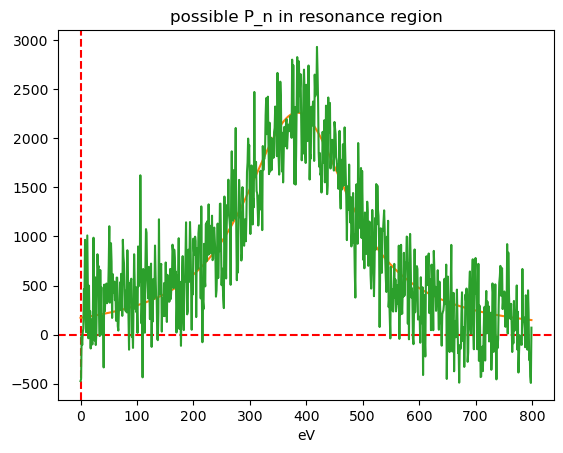

In [40]:
# print(tu, td)
tau_up = 36.2539
tau_dn = 78.9824
g_se = 1/tau_up - 1/tau_dn
P_he = g_se/(1/tau_up)
P_rb = 0.8
f = 0.4
res_japan = 0.756
res_usa = 0.7337
print((res_japan+res_usa)/2)

print('tau_up =', tau_up, ' tau_down =',tau_dn)
print('gamma_SE: ',g_se)
print('Best P_He: ',P_he)
print('guess P_Rb: ', P_rb)
print('"some factor": ', f)

## EQUATION: P_n = tanh(n*sigma_0*l*lambda*P_He) 
# number density n = 3.197*10^19 1/cm^3 (2 bar cell), cell length l = 11 cm, absorption cross section for 1 A sigma_0 = ~3000 barns

n = 4.91*10**(19) #1/cm^3
l = 10.8 #cm
sigma_0 = 2970*10**(-24) #barns to cm^2
lamb = 0.342  ## Angstrom to cm

testPn = np.tanh(n*sigma_0*l*lamb*P_he*P_rb*f)
print(f'estimate P_n for 0.7 eV resonance: {testPn}')

h = 6.62607015e-34  ## joule-seconds
m = 1.67492749804e-27 ## kg
eV_to_J = 1.602176565e-19 ## conversion factor
m_to_A = 1e10 ## m to Angstrom converstion factor

x_tof = xdata
fpl = 23.46 ## flight path length estimate
# print(len(x_tof))
# print(x_tof[384:387])
# print(0.5*(1.6749286*10**(-27))*((23.5/(1.965*1000)))**2*(6.24151*10**18))
t_to_eV_test = 0.5*(1.6749286*10**(-27))*((fpl/(x_tof*1000)))**2*(6.24151*10**18) ##*1000 seems to work
print(t_to_eV_test[384:387])

E_res = t_to_eV_test
p_res = np.sqrt(2*m*E_res*eV_to_J)
lamb_res = h/p_res*m_to_A
# print(lamb)
# print(f'Energy {E_2} [eV] equivalent to {np.round(lamb_2,5)} [Angstrom]\n')
P_n_res = np.tanh(n*sigma_0*l*lamb_res*P_he*P_rb*f)
# print(f'estimate P_n at 0.75 eV: {P_n_res[380]}')

plt.title('possible P_n in resonance region')
plt.plot(E_res, P_n_res)
plt.axvline(x = E_res[380], ls = '--', c = 'r')
plt.axhline(y = np.tanh(n*sigma_0*l*lamb_res[380]*P_he*P_rb*f), ls = '--', c = 'r')
plt.xlabel('eV')

ch = 3
r  = 100
ydata = bgsub_D[r][ch][bef_res_reg[1]-bef_res_reg[0]:aft_res_reg[0]-bef_res_reg[0]] 
plt.plot(voigt_D[r][ch])
plt.plot(ydata)
plt.show()




# plot this better

In [41]:
%matplotlib qt

# Sample data
r = 550
ch = 8
x = E_res
y1 = voigt_D[r][ch]
y2 = P_n_res
ydata = bgsub_D[r][ch][bef_res_reg[1]-bef_res_reg[0]:aft_res_reg[0]-bef_res_reg[0]] 

f = 0.4
f_bot = 0.3
f_top = 0.5
P_n_res = np.tanh(n*sigma_0*l*lamb_res*P_he*P_rb*f)*100
P_n_res_bot = np.tanh(n*sigma_0*l*lamb_res*P_he*P_rb*f_bot)*100
P_n_res_top = np.tanh(n*sigma_0*l*lamb_res*P_he*P_rb*f_top)*100
y2 = P_n_res

# Create the main plot
fig, ax1 = plt.subplots()

# Plot the first dataset
ax1.plot(x, y2, color='red', label=f'$P_n$, $f$ = {f}')
ax1.set_ylabel(r'$P_n$ [%]', color='red', fontsize='large')
ax1.set_xlabel('Energy [eV]', fontsize='large')
ax1.tick_params(axis='x', labelsize = 'large')
ax1.tick_params(axis='y', labelcolor='red', labelsize = 'large')
plt.fill_between(x, P_n_res_bot, P_n_res_top, color='pink', alpha=0.7, label=f'$f$ = {f_bot} - {f_top}')
plt.ylim(0,20)

# Create a twin axes sharing the x-axis
ax2 = ax1.twinx()

# Plot the second dataset

ax2.plot(x, ydata, color ='blue',alpha = 0.6)
ax2.plot(x, y1, ls = '--', color='cyan', alpha = 0.6, label='Resonance fit')
# ax2.set_xlabel('Energy [eV]',fontsize = 'large')
# ax2.set_ylabel('counts [arbitrary]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_yticks([])

# Create a twin axes sharing the x-axis
# ax3 = ax1.twinx()

# Plot the second dataset
# ax3.plot(x, ydata, color='red', label='Dataset 3')
# ax2.plot(x, ydata)
# ax3.set_ylabel('Y-axis 2', color='red')
# ax3.tick_params(axis='y', labelcolor='red')

# Add legends
# fig.legend(loc="upper right", bbox_to_anchor=(0.1, 0.95))


# Display the plot

plt.title(r'Estimate $P_n$ over resonance region', fontsize = 'xx-large')

# plt.xticks(np.arange(-1.0,4.0, 0.5),fontsize = 'large')
ax1.grid(True, which='both',axis = 'both', alpha = 0.75, ls = ':')
ax1.minorticks_on()
# plt.xticks(fontsize = 'xx-large')
# plt.yticks(fontsize = 'x-small')
fig.legend(loc="upper right", bbox_to_anchor=(0.90, 0.88))

# plt.ylabel('NMR Signal Amplitude [mV]',fontsize = 'x-large')
# plt.xlabel('Energy [eV]',fontsize = 'x-large')

# plt.legend(fontsize = 'medium')
plt.show()

In [42]:
plt.plot(x,y2)
plt.plot(x,P_n_res_bot)
plt.plot(x,y2-(y2-P_n_res_bot), ls ='--')

In [43]:
# Plot the first dataset
plt.plot(x, y2, color='red', label=f'$P_n$, $f$ = {f}')
plt.ylabel(r'$P_n$ [absolute]', color='red')
plt.tick_params(axis='y', labelcolor='red')
plt.fill_between(x, P_n_res_bot, P_n_res_top, color='pink', alpha=0.5, label=f'$f$ = {f_bot} - {f_top}')
plt.ylim(0,0.3)

# Create a twin axes sharing the x-axis
# ax2 = ax1.twinx()

# Plot the second dataset

plt.plot(x, ydata/(np.max(y1)), color ='blue',alpha = 0.6)
plt.plot(x, y1/(np.max(y1)), ls = '--', color='cyan', label='Resonance fit')
plt.xlabel('Energy [eV]',fontsize = 'large')

plt.show()

### testing area

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# Proper shifting without wraparound
@njit
def shift_trace(trace, shift_bins):
    out = np.zeros_like(trace)
    if shift_bins > 0:
        for i in range(len(trace) - shift_bins):
            out[i + shift_bins] = trace[i]
    elif shift_bins < 0:
        for i in range(-shift_bins, len(trace)):
            out[i + shift_bins] = trace[i]
    else:
        for i in range(len(trace)):
            out[i] = trace[i]
    return out

# Alignment function using true shifting
@njit
def align_cut_jit(ys, xs_arr, extendedr, offset, HeNorms):
    n_traces = ys.shape[0]
    trace_len = ys.shape[1]
    ext_len = trace_len + 2 * extendedr
    cut_len = ext_len - 2 * ((extendedr * 2) + 1)

    tempys_cut = np.zeros((n_traces, cut_len), dtype=np.float64)
    tempxs_cut = np.zeros(cut_len, dtype=np.float64)

    for p in range(n_traces):
        padded = np.zeros(ext_len, dtype=np.float64)
        for i in range(trace_len):
            padded[i + extendedr] = ys[p, i]

        shifted = shift_trace(padded, offset[p])

        start = (extendedr * 2) + 1
        end = ext_len - ((extendedr * 2) + 1)
        for i in range(end - start):
            tempys_cut[p, i] = shifted[start + i] / HeNorms[p]

    x_cut_amt = int((trace_len - cut_len) / 2)
    for i in range(cut_len):
        tempxs_cut[i] = xs_arr[x_cut_amt + i]

    return tempys_cut, tempxs_cut

# === Simulation ===
np.random.seed(1)
n_traces = 5
trace_len = 120
extendedr = 15

xs_arr = np.linspace(-30, 90, trace_len)
offset = np.array([10, -10, 5, 0, -5], dtype=np.int32)

ys = np.zeros((n_traces, trace_len))
for i in range(n_traces):
    gamma_pos = 60 + offset[i]
    if 1 <= gamma_pos < trace_len - 1:
        ys[i, gamma_pos - 1] = 50
        ys[i, gamma_pos]     = 100
        ys[i, gamma_pos + 1] = 50
    ys[i] += np.random.normal(0, 0.5, size=trace_len)
    for j in range(gamma_pos + 1, trace_len):
        ys[i, j] += 8 * np.exp(-(j - gamma_pos) / 15)

HeNorms = np.ones(n_traces)

# Align using true shift
aligned_data, aligned_time = align_cut_jit(ys, xs_arr, extendedr, offset, HeNorms)

# === Plotting ===
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

# Before alignment
for i in range(n_traces):
    axs[0].plot(xs_arr, ys[i], label=f'Trace {i} (offset={offset[i]} bins)')
axs[0].axvline(0, color='k', linestyle='--', label='Ideal t0')
axs[0].set_title("Original Traces: Gamma Flash Misaligned")
axs[0].set_ylabel("Signal")
axs[0].legend()
axs[0].grid(True)

# After alignment
for i in range(n_traces):
    axs[1].plot(aligned_time, aligned_data[i], label=f'Trace {i}')
axs[1].axvline(0, color='k', linestyle='--', label='Aligned t0')
axs[1].set_title("Aligned Traces: Gamma Flash Aligned at t0")
axs[1].set_xlabel("Time (bins)")
axs[1].set_ylabel("Normalized Signal")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [15]:
## try with only 2nd order poly 
@njit
def poly2_fit(x, y):
    """
    Least squares fit for y = a*x^2 + b*x + c.
    Equivalent to scipy.odr with polynomial(2).
    
    Parameters:
        x: 1D array of inputs
        y: 1D array of outputs
    
    Returns:
        coeffs: 1D array [a, b, c]
    """
    n = x.shape[0]
    A = np.empty((n, 3))
    for i in range(n):
        xi = x[i]
        A[i, 0] = xi * xi
        A[i, 1] = xi
        A[i, 2] = 1.0

    ATA = A.T @ A
    ATy = A.T @ y
    coeffs = np.linalg.solve(ATA, ATy)
    return coeffs

@njit
def poly2_predict(x, coeffs):
    """Evaluate y = a*x^2 + b*x + c for given x.
    Parameters:
        x: array of input values
        coeffs: array [a, b, c]
    Returns:
        y: predicted values"""
    return coeffs[0] * x**2 + coeffs[1] * x + coeffs[2]

@njit
def poly2_residuals(x, y, coeffs):
    """
    Compute residuals y - y_fit.
    """
    y_fit = poly2_predict(x, coeffs)
    return y - y_fit

Fitted Coefficients: [ 2.81213364e-04 -4.79271958e+00  2.65737500e+04]
residuals: [ 709.57434793  132.68896065  407.43004077 ... -525.04816886 -430.80999911
 -341.59627955]


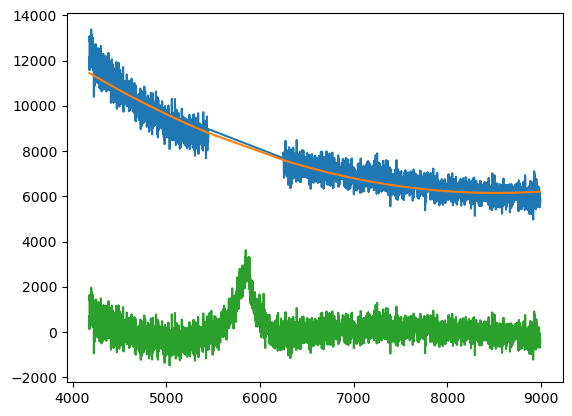

In [23]:
## testing new functions with just one

aft_res_reg = bg_reg2
bef_res_reg = bg_reg1

binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
x = np.append(x1,x2)

fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
ys_bgsub = []

ys = all_D[0][0]

fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
datasplice = np.append(fitdata1, fitdata2)
y = datasplice


# Fit model
coeffs = poly2_fit(x, y)
print("Fitted Coefficients:", coeffs)

# Predict
y_fit = poly2_predict(x, coeffs)

# Residuals (optional)
res = poly2_residuals(x, y, coeffs)
print("residuals:", res)

# data = odr.Data(x, y)
# poly_model2 = odr.polynomial(2)  # using third order polynomial model
# odr_obj = odr.ODR(data, poly_model2)
# output = odr_obj.run()  # running ODR fitting
# poly2 = np.poly1d(output.beta[::-1])
# poly_y2 = poly2(x)

fullpoly_y2 = poly2_predict(fullx, coeffs)


bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
ys_bgsub.append(bgsubtracted)
ys_bgsub[0] ## the array notation is left over from before...

plt.plot(x, y)
plt.plot(x, y_fit)
plt.plot(fullx, ys_bgsub[0])

In [12]:
### these both take a long time !!

bg_region1_beg = 4180
bg_region1_end = 5450
bg_region2_beg = 6250
bg_region2_end = 8992
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]

## change to 2nd order poly in cleaned up version
start = time.time()

def bg_fitsubtract_noseq(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
    if len(ys)-1 >= 13:
        emessage = ('bg_ fit does not work for 6Li yet')
#         logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    for ch in range(0,len(ys)-1):
        fitdata1 = ys[ch][bef_res_reg[0]: bef_res_reg[1]]
        fitdata2 = ys[ch][aft_res_reg[0]: aft_res_reg[1]]
        datasplice = np.append(fitdata1, fitdata2)
        y = datasplice
        data = odr.Data(x, y)
        poly_model2 = odr.polynomial(2)  # using third order polynomial model
        odr_obj = odr.ODR(data, poly_model2)
        output = odr_obj.run()  # running ODR fitting
        poly2 = np.poly1d(output.beta[::-1])
        poly_y2 = poly2(x)
        fullpoly_y2 = poly2(fullx)
        bgsubtracted = ys[ch][bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
        ys_bgsub.append(bgsubtracted)
    return ys_bgsub ## the array notation is left over from before...

## background subtraction currently only for NaI detectors
num_fittingchs = numchannels-1  ## removes the Li detector, assumes it is there
bgsub_D = np.zeros((numruns_tot_D, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
bgsub_U = np.zeros((numruns_tot_U, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
times1 = []

for r in range(0, len(all_D)-600): ## for every run
    print(r)
    start = time.time()
#     if channels[ch] == 'ch_24':
#         emessage = ('bg_ fit does not work for 6Li yet')
#         logger.error('run '+run_num + emessage)
#         raise Exception(emessage)
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
    bgsub_D[r] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_D[r])
    bgsub_U[r] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_U[r])
    end = time.time()
    times1.append(end-start)
    print('run took '+str(end-start))

########################################################################## two attempts. both bad.
    
bg_region1_beg = 4180
bg_region1_end = 5450
bg_region2_beg = 6250
bg_region2_end = 8992
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]

## change to 2nd order poly in cleaned up version
start = time.time()

def bg_fitsubtract_noseq(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
    fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
    fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
    datasplice = np.append(fitdata1, fitdata2)
    y = datasplice
    data = odr.Data(x, y)
    poly_model2 = odr.polynomial(2)  # using third order polynomial model
    odr_obj = odr.ODR(data, poly_model2)
    output = odr_obj.run()  # running ODR fitting
    poly2 = np.poly1d(output.beta[::-1])
    poly_y2 = poly2(x)
    fullpoly_y2 = poly2(fullx)
    bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
    ys_bgsub.append(bgsubtracted)
    return ys_bgsub[0] ## the array notation is left over from before...

## background subtraction currently only for NaI detectors
num_fittingchs = numchannels-1  ## removes the Li detector, assumes it is there
bgsub_D = np.zeros((numruns_tot_D, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
bgsub_U = np.zeros((numruns_tot_U, num_fittingchs,fullrange), dtype = np.float64) ## num runs, channels, range of bg_ subtraction
times2 = []

for r in range(0, len(all_D)-600): ## for every run
    print(r)
    start = time.time()
    for ch in range(0, num_fittingchs): ## and every channel (except 6Li)
        if channels[ch] == 'ch_24':
            emessage = ('bg_ fit does not work for 6Li yet')
            logger.error('run '+run_num + emessage)
            raise Exception(emessage)
#         print(r, ch)
#         print(channels[ch])
#         print(len(bgsub_D[r][ch]))
#         print(len(all_D[r][ch]))
        bgsub_D[r][ch] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_D[r][ch])
        bgsub_U[r][ch] = bg_fitsubtract_noseq(bg_reg1,bg_reg2, all_U[r][ch])
    end = time.time()
    times2.append(end-start)
    print('run took '+str(end-start))

0
run took 6.200705051422119
1
run took 6.403738975524902
2
run took 6.116412162780762
3
run took 6.206817626953125
4
run took 6.945209741592407
5
run took 6.048011064529419
6
run took 5.800512075424194
7
run took 6.515385150909424
8
run took 6.8105669021606445
9
run took 6.4586341381073
10
run took 6.311155796051025
11
run took 5.996998310089111
12
run took 6.171201229095459
13
run took 6.385328769683838
14
run took 6.496899604797363
15
run took 6.669878005981445
16
run took 6.46414041519165
17
run took 6.148305654525757
18
run took 5.908167600631714
19
run took 6.143528938293457
20
run took 6.178879499435425
21
run took 6.235410690307617
22
run took 6.175605058670044
23
run took 6.174319505691528
24
run took 6.118877649307251
25
run took 6.224642992019653
26
run took 5.90382981300354
27
run took 6.631624698638916
28
run took 6.362154960632324
29
run took 6.313245058059692
30
run took 6.247541189193726
31
run took 6.083781957626343
32
run took 6.275695562362671
33
run took 6.300366640

In [6]:
numsequences = []
run_ON_D = []
run_ON_U = []

run_OFF_D = []
run_OFF_U = []
# totnumchan = len(run_asyms_D[0])+len(run_asyms_U_noLi[0])

numsequences = []
folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders

for i in range(0,len(runslist_D)):
    runname = folderpath+'/ONOFF_D/'+runslist_D[i]
    print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_seq = f.attrs.get('sequences')
        numsequences.append(num_seq)
        rundat = []
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        for i in range(0,numchannels):
            dataset = f[channels[i]+'/added_pulses/'+channels[i][:2]+' '+channels[i][3:5]]  ##change this to match channels[i]
            ON_data = np.array(dataset[0])
            rundat.append(ON_data)
            OFF_data = np.array(dataset[1])
            run_OFF_D.append(OFF_data)
        run_ON_D.append(rundat)
        f.close()
        folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders

F:\LANL/processed_data/runs12034-12363//ONOFF_D/12034_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12035_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12036_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12037_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12038_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12039_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12040_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12041_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12042_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12043_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12044_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12045_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12046_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12047_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12048_ONOFF_D.h5
F:\LANL/processed_data/ru

F:\LANL/processed_data/runs12034-12363//ONOFF_D/12167_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12168_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12169_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12170_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12171_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12172_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12173_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12174_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12175_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12176_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12177_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12178_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12179_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12180_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12181_ONOFF_D.h5
F:\LANL/processed_data/ru

F:\LANL/processed_data/runs12034-12363//ONOFF_D/12299_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12300_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12301_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12302_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12303_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12304_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12305_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12306_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12307_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12308_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12309_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12310_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12311_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12312_ONOFF_D.h5
F:\LANL/processed_data/runs12034-12363//ONOFF_D/12313_ONOFF_D.h5
F:\LANL/processed_data/ru

In [7]:
%matplotlib qt
run_ON_D = np.asarray(run_ON_D)
run_ON_U = np.asarray(run_ON_U)

run_OFF_D = np.asarray(run_OFF_D)
run_OFF_U = np.asarray(run_OFF_U)
print(run_ON_D.shape)
print(len(run_ON_D[0]))
print(len(run_ON_D[0][0]))
# print(len(run_ON_U[0]))
# print(len(run_ON_U[0][0]))
for ch in range(12):
    plt.plot(xs,run_ON_D[0][ch])

(330, 13, 8992)
13
8992


### now bg fit each run's ON

In [18]:
r = 19
ch = 5

res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
xdata = xs[bg_reg1[0]:bg_reg2[1]]
# xdata = xs[res_reg[0]:res_reg[1]]*1e-6

plt.plot(xs,run_ON_D[r][ch])
plt.plot(xdata, ON_bgsub[r][ch], lw = '1.0', label='trouble run')
plt.plot(xs,run_ON_D[r-1][ch])
plt.plot(xdata, ON_bgsub[r-1][ch], lw = '1.0', label='normal?')
plt.legend()
plt.show()

In [12]:

## change to 2nd order poly in cleaned up version
# start = time.time()

def bg_fitsubtract_np(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
#     ys_bgsub = []
    fitdata1 = ys[bef_res_reg[0]: bef_res_reg[1]]
    fitdata2 = ys[aft_res_reg[0]: aft_res_reg[1]]
    datasplice = np.append(fitdata1, fitdata2)
    y = datasplice
    
#     data = odr.Data(x, y)
#     poly_model2 = odr.polynomial(2)  # using third order polynomial model
#     odr_obj = odr.ODR(data, poly_model2)
#     output = odr_obj.run()  # running ODR fitting
#     poly2 = np.poly1d(output.beta[::-1])
#     poly_y2 = poly2(x)
#     fullpoly_y2 = poly2(fullx)
#     bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
    
    polyfit_param = np.polyfit(x,y,2)
    p = np.poly1d(polyfit_param)
    poly_y2_np = p(x)
    fullpoly_y2_np = p(fullx)
    bgsubtracted = ys[bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2_np 
#     ys_bgsub.append(bgsubtracted)
    return bgsubtracted

## background subtraction currently only for NaI detectors
num_fittingchs = len(run_ON_D[0])-1  ## removes the Li detector, assumes it is there
# numpoints = len(run_ON_D[0][0])
ON_bgsub_np = np.zeros((numruns,num_fittingchs,fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction
OFF_bgsub_np = np.zeros((numruns,num_fittingchs,fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction

# for r in range(0, 3):
for r in range(0, numruns):
    print('run '+str(r))
    for i in range(0, num_fittingchs):
#         print(i)
#         if channels[i] == 'ch_24':
#             emessage = ('bg_ fit does not work for 6Li yet')
#             logger.error('run '+run_num + emessage)
#             raise Exception(emessage)
        ON_bgsub_np[r][i]  = bg_fitsubtract_np(bg_reg1,bg_reg2, run_ON_D[r][i])
#         OFF_bgsub[r][i] = bg_fitsubtract(bg_reg1,bg_reg2, OFF_sums[r][i])

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
run 20
run 21
run 22
run 23
run 24
run 25
run 26
run 27
run 28
run 29
run 30
run 31
run 32
run 33
run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49
run 50
run 51
run 52
run 53
run 54
run 55
run 56
run 57
run 58
run 59
run 60
run 61
run 62
run 63
run 64
run 65
run 66
run 67
run 68
run 69
run 70
run 71
run 72
run 73
run 74
run 75
run 76
run 77
run 78
run 79
run 80
run 81
run 82
run 83
run 84
run 85
run 86
run 87
run 88
run 89
run 90
run 91
run 92
run 93
run 94
run 95
run 96
run 97
run 98
run 99
run 100
run 101
run 102
run 103
run 104
run 105
run 106
run 107
run 108
run 109
run 110
run 111
run 112
run 113
run 114
run 115
run 116
run 117
run 118
run 119
run 120
run 121
run 122
run 123
run 124
run 125
run 126
run 127
run 128
run 129
run 130
run 131
run 132
run 133
run 134
run 135
run 136
run 137
run 13

In [31]:
r = 45
ch = 8

res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
xdata = xs[bg_reg1[0]:bg_reg2[1]]
# xdata = xs[res_reg[0]:res_reg[1]]*1e-6

plt.plot(xs,run_ON_D[r][ch])
# plt.plot(xdata, ON_bgsub[r][ch], lw = '1.0', label='trouble run')
plt.plot(xdata, ON_bgsub_np[r][ch], lw = '1.0', label='trouble run np version')
plt.plot(xs,run_ON_D[r-1][ch])
plt.plot(xdata, ON_bgsub[r-1][ch], lw = '1.0', label='normal?')
plt.axhline(y = 7430)
plt.axhline(y = 5448)
plt.axvline(x = 1.968)


plt.legend()
plt.show()

In [20]:
print(len(ON_bgsub))
print(len(ON_bgsub[0]))

print(len(ON_bgsub[0][0]))

print(len(run_ON_D))
print(len(run_ON_D[0]))

print(len(run_ON_D[0][0]))


330
12
4812
330
13
8992


In [21]:
r = 19
ch = 5

binstot = bg_reg2[1]-bg_reg1[0]  ## total number of bins in whole region
x1 = np.arange(bg_reg1[0], bg_reg1[1],1)
x2 = np.arange(bg_reg2[0], bg_reg2[1],1)
x = np.append(x1,x2)
fullx = np.arange(bg_reg1[0], bg_reg2[1],1) ## an array of every x bin in entire region
#     ys_bgsub = []
fitdata1 = run_ON_D[r][ch][bg_reg1[0]: bg_reg1[1]]
fitdata2 = run_ON_D[r][ch][bg_reg2[0]: bg_reg2[1]]
datasplice = np.append(fitdata1, fitdata2)
y = datasplice

test = np.polyfit(x,y,2)
print(test)
p = np.poly1d(test)

# data = odr.Data(x, y)
# poly_model2 = odr.polynomial(2)  # using third order polynomial model
# odr_obj = odr.ODR(data, poly_model2)
# output = odr_obj.run()  # running ODR fitting
# poly2 = np.poly1d(output.beta[::-1])
poly_y2_np = p(x)
fullpoly_y2_np = p(fullx)
bgsubtracted = run_ON_D[r][ch][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2_np  ## subtracts RealData-BackgroundFit

[ 1.89915030e-04 -3.22980410e+00  1.73365733e+04]


In [22]:
res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
xdata = xs[bg_reg1[0]:bg_reg2[1]]
# xdata = xs[res_reg[0]:res_reg[1]]*1e-6

plt.plot(xs,run_ON_D[r][ch])
plt.plot(xdata, bgsubtracted, lw = '1.0', label='trouble run')
plt.plot(xs,run_ON_D[r][ch])
plt.plot(xdata, ON_bgsub[r][ch], lw = '1.0', label='Old polyfit')
plt.plot(xs,run_ON_D[r-1][ch])
plt.plot(xdata, ON_bgsub[r-1][ch], lw = '1.0', label='normal?')
plt.legend()
plt.show()

In [17]:
# test = np.polyfit(x,y,3)
# print(test)
# p = np.poly1d(test)
# print(p(x))
# plt.plot(np.poly1d(test))
plt.plot(xdata,p(x))

ValueError: x and y must have same first dimension, but have shapes (4812,) and (4012,)

### now voigt fitting

In [23]:
# now voigt

def voigt2(x, sig, gam, xshift, amp):
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

# res_region_beg = 5450
# res_region_end = 6250
res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

# xdata = xs[res_reg[0]:res_reg[1]]*1e-6  ## just change all xs to ms and one array
xdata = xs[res_reg[0]:res_reg[1]]  ## just change all xs to ms and one array

# In[22]:

# resonance region is assumed to be in between 2 background regions. Could maybe change this. 11.22.24
# start = time.time()
 
def voigt_fitting(bef_res_reg, aft_res_reg,xs,ys):
    fit_curves = []
    parameters = []
#     for ch in range(0, len(ys)): ## number of sequences, usually 13
    ydata = ys[bef_res_reg[1]-bef_res_reg[0]:aft_res_reg[0]-bef_res_reg[0]] 
    popt, pcov = curve_fit(voigt2, xs, ydata, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))
#     popt, pcov = curve_fit(voigt2, xs, ydata)
    fitted_curve = voigt2(xs, popt[0],popt[1],popt[2],popt[3],) ## sigma, gamma, xshift (res. center), amp. related thing
#     fit_curves.append(fitted_curve)
    fit_params = popt
    fit_errs = np.diagonal(pcov)
#     parameters.append([fit_params,fit_errs])
    return fitted_curve, [fit_params,fit_errs]

res_size = res_reg[1]-res_reg[0] 
ON_vfit = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),res_size), dtype = np.float64) ## runs, channels, range of V_ subtraction
OFF_vfit = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),res_size), dtype = np.float64)

ON_vfit_params = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),2,4), dtype = np.float64) ## channels, sequences,[params, param_errs], [sigma, gamma, shift, amp thing]
OFF_vfit_params = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),2,4), dtype = np.float64)

# for r in range(0, numruns): 
# #         if channels[i] == 'ch_24':
# #             emessage = ('bg_ fit does not work for 6Li yet')
# #             logger.error('run '+run_num + emessage)
# #             raise Exception(emessage)
# #         try:
#         ON_vfit[r], ON_vfit_params[r]  = voigt_fitting(bg_reg1,bg_reg2,xdata, ON_bgsub[r])
#         print(r)
# #             OFF_vfit[r][i], OFF_vfit_params[r][i] = voigt_fitting(bg_reg1,bg_reg2,xdata, OFF_bgsub[r][i])
# #         except Exception as e:
# #             logger.error('run '+run_num + ' failed during Voigt fitting')
# #             logger.exception(e)

for r in range(0, numruns): 
    print(r)
    for i in range(0, len(ON_bgsub[0])): 
#         if channels[i] == 'ch_24':
#             emessage = ('bg_ fit does not work for 6Li yet')
#             logger.error('run '+run_num + emessage)
#             raise Exception(emessage)
        try:
            ON_vfit[r][i], ON_vfit_params[r][i]  = voigt_fitting(bg_reg1,bg_reg2,xdata, ON_bgsub_np[r][i])
#             OFF_vfit[r][i], OFF_vfit_params[r][i] = voigt_fitting(bg_reg1,bg_reg2,xdata, OFF_bgsub[r][i])
        except:
            print('still testing this')
            print('run '+str(r)+' ch '+str(i))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
still testing this
run 45 ch 7
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
still testing this
run 128 ch 7
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
still testing this
run 227 ch 0
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253

#### for some reason run=79, ch=11 fails and run=19, ch =5 looks terrible. run=83, ch. 9

#### np version has its own trouble. Look at r = 45, ch = 7. r = 128, ch = 7.

In [24]:
r = 79
ch = 11
xdata = xs[res_reg[0]:res_reg[1]] 
ydata = ON_bgsub[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

plt.plot(xdata,ON_vfit[r][ch])
plt.plot(xdata,ydata)
print(ON_vfit_params[r][ch])

[[3.25169444e-02 2.54842367e-02 1.96793778e+00 3.58091374e+02]
 [8.09333616e-06 1.24033622e-05 6.32309609e-07 7.81354484e+01]]


In [91]:
print(len(ON_vfit))
print(len(ON_vfit[0]))
print(len(ON_vfit[0][0]))

330
12
800


In [176]:
## look at fitting manually

r = 45
ch = 7

res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]
xdata = xs[res_reg[0]:res_reg[1]]
ydata = ON_bgsub[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata_np = ON_bgsub_np[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

def voigt2(x, sig, gam, xshift, amp):
#     xshift=1.9678
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

# popt, pcov = curve_fit(voigt2, xdata, ydata)
# popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,1.5,-np.inf], [np.inf,np.inf,2.0, np.inf]))
popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))
popt_np, pcov_np = curve_fit(voigt2, xdata, ydata_np, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))

print(popt)
print(pcov)

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
fitted_curve_np = voigt2(xdata, popt_np[0],popt_np[1],popt_np[2],popt_np[3],)

print(max(fitted_curve))
print((popt[3])*np.sqrt(2*np.pi))
print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
print((popt[3])/(popt[0]))
print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [177]:
print(ydata[10:20])
plt.plot(xdata, fitted_curve, label = 'regular version')
plt.plot(xdata, fitted_curve_np, label = 'np version')

# plt.plot(xs, ON_bgsub[1][0])
plt.legend()
plt.plot(xdata,ydata)

[ -64.17848146 -167.73496416 -458.12599825  367.63461155  311.708419
 -208.39184397 -330.97554306 -349.31700928  -34.24701699 -199.09877572]


NameError: name 'fitted_curve_np' is not defined

In [ ]:
print('hi')

In [218]:
## try setting things constant for trouble ones
r = 45
ch = 7

res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]
xdata = xs[res_reg[0]:res_reg[1]]
ydata = ON_bgsub[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
# ydata = ON_bgsub_np[r][ch][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

# sig = 
# gam = 
# xshift = 

def voigt3(x, amp):
#     xshift=1.9678
    ## ch 5:
#     s = 0.043253230
#     g = 0.006067
#     res_loc = 1.9698596
    ## ch 11:
#     s = 0.039110152
#     g = 0.012317655539375172
#     res_loc = 1.9617306244821926
    ## ch 9:
#     s = 0.042199785942949083
#     g = 0.0031533887758442643
#     res_loc = 1.962500989185792
    ## ch 7:
    s = 0.042522924601082
    g = 0.0056886589305687055
    res_loc = 1.9674671154674273
#     g = 0
    fit = voigt_profile(x-res_loc, s, g)*amp
    return fit

# popt, pcov = curve_fit(voigt2, xdata, ydata)
# popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,1.5,-np.inf], [np.inf,np.inf,2.0, np.inf]))
popt, pcov = curve_fit(voigt3, xdata, ydata)

print(popt)
print(pcov)

fitted_curve = voigt3(xdata, popt[0],)

# print(max(fitted_curve))
# print((popt[3])*np.sqrt(2*np.pi))
# print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
# print((popt[3])/(popt[0]))
# print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

print(ydata[10:20])
plt.plot(xdata, fitted_curve)
# plt.plot(xs, ON_bgsub[1][0])
plt.plot(xdata,ydata)

[160.4606207]
[[7.88684477]]
[ -64.17848146 -167.73496416 -458.12599825  367.63461155  311.708419
 -208.39184397 -330.97554306 -349.31700928  -34.24701699 -199.09877572]


In [ ]:
plt.plot(xdata, fitted_curve, label = 'regular version')
plt.plot(xdata, fitted_curve_np, label = 'np version')

# plt.plot(xs, ON_bgsub[1][0])
plt.legend()
plt.plot(xdata,ydata)

In [ ]:
## changing to the constants above seems to be working (except those with bad poly fitting before)

In [79]:
print(ON_vfit[83][9][10:20])
print(ON_vfit_params[83][9][0])
print(ON_vfit_params[83][9][0][2])

print(ON_vfit[83][10][10:20])
print(ON_vfit_params[83][10][0])
print(ON_vfit_params[83][10][0][2])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.]
0.0
[19.05119416 19.17295857 19.2960278  19.42042326 19.54616688 19.67328107
 19.80178877 19.93171347 20.06307918 20.19591052]
[3.95943782e-02 1.06396179e-02 1.96622946e+00 1.79617545e+02]
1.9662294640152356


In [210]:
s=0
e = 46
print(np.average(ON_vfit_params[s:e,ch,0,2]))


1.9243503465899032


In [18]:
run_asyms_D1 = []
run_asyms_D2 = []

run_asyms_U = []
run_asyms_U_noLi = []
# totnumchan = len(run_asyms_D[0])+len(run_asyms_U_noLi[0])
run_asyms_All = []

numsequences = []
folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders
# print(folderpath)
# for i in range(0,len(runslist_D)):
#     runname = folderpath+'/asym_D/'+runslist_D[i]
#     print(runname)
#     with h5py.File(runname, 'r') as f:
#         channels = list(f.keys())
#         numchannels = len(channels)-1
#         num_seq = f.attrs.get('sequences')
#         numsequences.append(num_seq)
# #         rundat = []
#         for j in range(0,numchannels):
# #             print(str(np.char.zfill(str(chan_enab[i]),2)))
# #             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
#             dataset = f[channels[j]+'/OFF/parameters']
#             data = np.array(dataset)
# #             rundat_asym.append(data)
#             run_asyms_D.append(data)
#         f.close()
#         folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders

for i in range(0,len(runslist_D)):
    runname = folderpath+'/asym_D/'+runslist_D[i]
#     print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_seq = f.attrs.get('sequences')
        numsequences.append(num_seq)
#         rundat = []
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        dataset = f['ch_06/OFF/parameters']
        data = np.array(dataset)
#             rundat_asym.append(data)
        run_asyms_D1.append(data)
        dataset2 = f['ch_06/ON/parameters']
        data2 = np.array(dataset2)
#             rundat_asym.append(data)
        run_asyms_D2.append(data2)
        f.close()
        folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders
        
# for i in range(0,len(runslist_U)):
#     runname = folderpath+'/asym_U/'+runslist_U[i]
# #     print(runname)
#     with h5py.File(runname, 'r') as f:
#         channels = list(f.keys())
#         numchannels = len(channels)-1
# #         num_seq = f.attrs.get('sequences')
# #         numsequences.append(num_seq)
# #         rundat = []
#         for j in range(0,numchannels):
# #             print(str(np.char.zfill(str(chan_enab[i]),2)))
# #             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
#             dataset = f[channels[j]]
# #             data = np.array(dataset)
# #             rundat_asym.append(data)
#             run_asyms_U[i][j] = dataset
#         f.close()

In [19]:
print(channels, numchannels, num_seq, numsequences)

['ch_00', 'ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07', 'ch_08', 'ch_09', 'ch_10', 'ch_11', 'xs '] 12 11 [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1

In [20]:
run_asyms_D1 = np.asarray(run_asyms_D1)
# print(len(run_asyms_D))
# print(len(run_asyms_D[0]))
# print(len(run_asyms_D[0][0]))
# print(len(run_asyms_D[0][0][0]))
print(run_asyms_D1.shape)
# print(len(run_asyms_D[0][0][0][0]))
# print((run_asyms_D[0]))
# print((run_asyms_D[0][0]))
# print((run_asyms_D[0][0][0]))
# print((run_asyms_D[0][0][0][2]))
# print((run_asyms_D[0:10,:][:][0][:,0,2]))
# print(run_asyms_D)

# print(run_asyms_D.size())
# test = run_asyms_D[0][:]
# print((test))
# test = 
# print(np.average())
print(np.vstack(run_asyms_D1).shape)
test = np.vstack(run_asyms_D1)
test[:,0,2]
print(np.average(test[:,0,0]))

%matplotlib qt
plt.hist(test[:,0,0], bins = 200)
print(np.average(test[:,0,0]))
print(np.std(test[:,0,0]))

(330,)
(4288, 2, 4)
0.03459672996325404
0.03459672996325404
0.01685389255261596


C:\Users\gabeo\AppData\Local\Temp\ipykernel_34628\2011416603.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_asyms_D1 = np.asarray(run_asyms_D1)


In [21]:
run_asyms_D2 = np.asarray(run_asyms_D2)
# print(len(run_asyms_D))
# print(len(run_asyms_D[0]))
# print(len(run_asyms_D[0][0]))
# print(len(run_asyms_D[0][0][0]))
print(run_asyms_D2.shape)
# print(len(run_asyms_D[0][0][0][0]))
# print((run_asyms_D[0]))
# print((run_asyms_D[0][0]))
# print((run_asyms_D[0][0][0]))
# print((run_asyms_D[0][0][0][2]))
# print((run_asyms_D[0:10,:][:][0][:,0,2]))
# print(run_asyms_D)

# print(run_asyms_D.size())
# test = run_asyms_D[0][:]
# print((test))
# test = 
# print(np.average())
print(np.vstack(run_asyms_D2).shape)
test2 = np.vstack(run_asyms_D2)
test2[:,0,2]
print(np.average(test2[:,0,0]))

%matplotlib qt
plt.hist(test2[:,0,0], bins = 200)
print(np.average(test2[:,0,0]))
print(np.std(test2[:,0,0]))

(330,)
(4288, 2, 4)
0.0342224996792375
0.0342224996792375
0.016904136721250622


C:\Users\gabeo\AppData\Local\Temp\ipykernel_34628\3054402300.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_asyms_D2 = np.asarray(run_asyms_D2)


In [22]:
print(run_asyms_D1.shape)
print(run_asyms_D2.shape)
print(len(test))
print(len(test2))

(330,)
(330,)
4288
4288


In [33]:
plt.hist(test[:,0,0], bins = 200, label = 'Ch 06, OFF states')
plt.hist(test2[:,0,0], bins = 200,label = 'Ch 06, ON states')

plt.legend()
print(np.average(test[:,0,0]))
print(np.std(test[:,0,0]))
print()
print(np.average(test2[:,0,0]))
print(np.std(test2[:,0,0]))
plt.xlabel('ms')
plt.title('sigma value ~'+str(len(run_asyms_D1)*13) +' sequences')

0.03459672996325404
0.01685389255261596

0.0342224996792375
0.016904136721250622


Text(0.5, 1.0, 'sigma value ~4290 sequences')

In [29]:
plt.hist(test2[:,0,1], bins = 200,label = 'Ch 06, ON states')
plt.hist(test[:,0,1], bins = 200, label = 'Ch 06, OFF states')
print(np.average(np.abs(test[:,0,1])))
print(np.std(np.abs(test[:,0,1])))
plt.legend()
plt.xlabel('ms')
plt.title('gamma value ~'+str(len(run_asyms_D1)*13) +' sequences')

0.009343947142149518
0.014317626856111891


Text(0.5, 1.0, 'gamma value ~4290 sequences')

In [31]:
plt.hist(test[:,0,2], bins = 200, label = 'Ch 06, OFF states')
plt.hist(test2[:,0,2], bins = 200,label = 'Ch 06, ON states')
print(np.average(test[:,0,2]))
print(np.std(test[:,0,2]))
print(len(run_asyms_D1))
print(np.average(test2[:,0,2]))
print(np.std(test2[:,0,2]))
plt.legend()

plt.xlabel('tof')
plt.title('x shift ~'+str(len(run_asyms_D1)*13) +' sequences')


1.9678181106932944
0.007745009092118807
330
1.9675429776725626
0.007752263092993295


Text(0.5, 1.0, 'x shift ~4290 sequences')

In [32]:
plt.hist(test[:,0,3], bins = 200, label = 'Ch 06, OFF states')
plt.hist(test2[:,0,3], bins = 200,label = 'Ch 06, ON states')
print(np.average(np.abs(test[:,0,3])))
print(np.std(np.abs(test[:,0,3])))
print(np.average(np.abs(test2[:,0,3])))
print(np.std(np.abs(test2[:,0,3])))
plt.legend()
plt.xlabel('unitless?')
plt.title('Amplitude ~'+str(len(run_asyms_D1)*13) +' sequences')


7.617075863267265
1.4454804296220267
7.460790221387746
1.44191868678733


Text(0.5, 1.0, 'Amplitude ~4290 sequences')

In [9]:
run_asyms_D = np.zeros((numruns,numchannels,numpoints), dtype=float) ## num runs, num channels, num points (one dataset per run per channel)
run_asyms_U = np.zeros((numruns,numchannels,numpoints), dtype=float)
run_asyms_U_noLi = run_asyms_U[:,:-1] ## take out 6Li in upstream (can this be done above?)
totnumchan = len(run_asyms_D[0])+len(run_asyms_U_noLi[0])
run_asyms_All = np.zeros((numruns,totnumchan,numpoints), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)

numsequences = []
folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders
print(folderpath)
for i in range(0,len(runslist_D)):
    runname = folderpath+'/asym_D/'+runslist_D[i]
#     print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_seq = f.attrs.get('sequences')
        numsequences.append(num_seq)
#         rundat = []
        for j in range(0,numchannels):
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
            dataset = f[channels[j]]
#             data = np.array(dataset)
#             rundat_asym.append(data)
            run_asyms_D[i][j] = dataset
        f.close()
        folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders

for i in range(0,len(runslist_U)):
    runname = folderpath+'/asym_U/'+runslist_U[i]
#     print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
#         num_seq = f.attrs.get('sequences')
#         numsequences.append(num_seq)
#         rundat = []
        for j in range(0,numchannels):
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
            dataset = f[channels[j]]
#             data = np.array(dataset)
#             rundat_asym.append(data)
            run_asyms_U[i][j] = dataset
        f.close()

F:\LANL/processed_data/runs12034-12363/


ValueError: could not convert string to float: 'OFF'

In [ ]:
folderpath = root+processedfolder+folderslist[0]
with h5py.File(folderpath+'/asym_bg_D/'+runslist_bg_D[0], 'r') as f: ## new arr_sizer
    dataset = f['ch 00']
    channels = list(f.keys())
    print(channels[-1])
    xsdataset = f[channels[-1]]
#     numchannels = len(channels)-1
    data = np.array(dataset)
    xs_bg = np.array(xsdataset)
    numpoints_bg = len(data)
    f.close()
print(numruns,numchannels,numpoints_bg)
# print(xs_bg)

In [ ]:
run_asyms_bg_D = np.zeros((numruns,numchannels,numpoints_bg), dtype=float) ## num runs, num channels, num points (one dataset per run per channel)
run_asyms_bg_U = np.zeros((numruns,numchannels,numpoints_bg), dtype=float)
run_asyms_bg_U_noLi = run_asyms_bg_U[:,:-1] ## take out 6Li in upstream (can this be done above?)
run_asyms_bg_All = np.zeros((numruns,totnumchan,numpoints_bg), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)

numsequences = []
folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders
print(folderpath)
for i in range(0,len(runslist_bg_D)):
    runname = folderpath+'/asym_bg_D/'+runslist_bg_D[i]
#     print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_seq = f.attrs.get('sequences')
        numsequences.append(num_seq)
#         rundat = []
        for j in range(0,numchannels):
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
            dataset = f[channels[j]]
#             data = np.array(dataset)
#             rundat_asym.append(data)
            run_asyms_bg_D[i][j] = dataset
        f.close()
        folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders

for i in range(0,len(runslist_bg_U)):
    runname = folderpath+'/asym_bg_U/'+runslist_bg_U[i]
#     print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
#         num_seq = f.attrs.get('sequences')
#         numsequences.append(num_seq)
#         rundat = []
        for j in range(0,numchannels):
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
            dataset = f[channels[j]]
#             data = np.array(dataset)
#             rundat_asym.append(data)
            run_asyms_bg_U[i][j] = dataset
        f.close()

In [ ]:
print(len(run_asyms_All))
print(len(run_asyms_All[0]))
print(len(run_asyms_All[0]))

run_asyms_U_noLi = run_asyms_U[:,:-1] ## take out 6Li in upstream (can this be done above?)
for i in range(numruns):
    run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))

In [ ]:
print(len(run_asyms_bg_All))
print(len(run_asyms_bg_All[0]))
print(len(run_asyms_bg_All[0]))

run_asyms_bg_U_noLi = run_asyms_bg_U[:,:-1] ## take out 6Li in upstream (can this be done above?)
for i in range(numruns):
    run_asyms_bg_All[i] = np.vstack((run_asyms_bg_U_noLi[i], run_asyms_bg_D[i]))


In [ ]:
ch_asyms_All = run_asyms_All.transpose(1, 0, 2) ## switches first array to channels and second array to pulses
ch_asyms_bg_All = run_asyms_bg_All.transpose(1, 0, 2) ## switches first array to channels and second array to pulses


In [ ]:
print(len(run_asyms_D))
print(len(run_asyms_U_noLi))
print(len(run_asyms_All))
print()
print(len(run_asyms_D[0]))
print(len(run_asyms_U_noLi[0]))
print(len(run_asyms_All[0]))
print()
print(len(run_asyms_D[0][0]))
print(len(run_asyms_U_noLi[0][0]))
print(len(run_asyms_All[0][0]))

In [ ]:
print(len(run_asyms_bg_D))
print(len(run_asyms_bg_U_noLi))
print(len(run_asyms_bg_All))
print()
print(len(run_asyms_bg_D[0]))
print(len(run_asyms_bg_U_noLi[0]))
print(len(run_asyms_bg_All[0]))
print()
print(len(run_asyms_bg_D[0][0]))
print(len(run_asyms_bg_U_noLi[0][0]))
print(len(run_asyms_bg_All[0][0]))

In [ ]:
# print(len(rundat_asym[0]))
print((run_asyms_U[7][-1]))
print((run_asyms_D[7][-1]))
print((run_asyms_U[7][-2]))
print((run_asyms_U_noLi[7][-1]))
print()
print((run_asyms_All[7][-2]))
print((run_asyms_All[7][-1]))

print()
print((run_asyms_U[0][0][500:520]))
print((run_asyms_U[0][1][500:520]))
print((run_asyms_U[0][6][500:520]))
print((run_asyms_U[1][0][500:520]))
print((run_asyms_U[1][6][500:520]))
print((run_asyms_U[5][9][500:520]))
print((run_asyms_U[14][12][500:520]))

In [ ]:
print(len(numsequences))
print((numsequences))

In [ ]:
## need to fix on off so that it is ON arr then OFF arr

rundat_ONOFF = []
numsequences = []
folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders
print(folderpath)
for i in range(0,len(runslist_D)):
    runname = folderpath+'/asym_D/'+runslist_D[i]
    print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_sequence = f.attrs.get('sequences')
        numsequences.append(num_sequence)
#         rundat = []
        for i in range(0,numchannels):
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
            dataset = f[channels[i]]
            data = np.array(dataset)
            rundat_ONOFF.append(data)
        f.close()

In [ ]:
# ## re-wrote the file...
# f = h5py.File(root+processedfolder+folderslist[0]+'asym_D/'+runslist_D[0], 'w') ## loads first run of first folder
# f.name
# dset = f.create_dataset("test", (14,8992))
# f.close()

In [10]:
# f = h5py.File(root+processedfolder+folderslist[0]+'asym_D/'+runslist_D[0], 'a')

# grp = f.create_group("subgroup")

In [11]:
## old?

with h5py.File('F:/LANL/processed_data/La_sample/asym_D/11143_asym_D' + '.h5', 'r') as f:
    print(f.attrs.keys())
    print(f.attrs.get('sequences'))
    print(f.attrs.get('rownames'))
    num_sequence = f.attrs.get('sequences')
    dataset = f['ch 00']
    data = np.array(dataset)
    f.close()
print(num_sequence)
print(dataset)
print(data)
print(len(data))

with h5py.File('F:/LANL/processed_data/La_sample/ONOFF_D/11143_ONOFF_D' + '.h5', 'r') as f:
    num_sequence = f.attrs.get('sequences')
    runONOFF = []
    for i in range(0,len(chan_enab)):
        print(str(np.char.zfill(str(chan_enab[i]),2)))
        dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        data = np.array(dataset)
        runONOFF.append(data)
    f.close()

<KeysViewHDF5 ['sequences']>
13
None
13
<Closed HDF5 dataset>
[ 2.2999511   0.69548797 -0.58615785 ... -0.05485336 -0.11336868
 -0.03639685]
8992


NameError: name 'chan_enab' is not defined

In [ ]:
print(num_sequence)
# print(dataset)
# print(data)
print(len(runONOFF)) ## channels
print(len(runONOFF[0])) ## ON + OFF arrays
print(len(runONOFF[0][0])) ## num points in each ON or OFF array

In [ ]:
print(h5py.File(root+processedfolder+folderslist[0]+'asym_D/'+runslist_D[0], 'r')['ch 00']) ## loads first run of first folder

In [ ]:
# for i in range(numruns):
#     run_asyms_D[i] = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[i])
#     run_asyms_U[i] = np.load(root+processedfolder+folders_start+'/asym_U/'+runslist_U[i])
#     run_asyms_U_noLi[i] = run_asyms_U[i,:-1].copy()
#     run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))


In [ ]:
print(len(run_asyms_D))
print(len(run_asyms_U_noLi))
print(len(run_asyms_All))
print()
print(len(run_asyms_D[0]))
print(len(run_asyms_U_noLi[0]))
print(len(run_asyms_All[0]))
print()
print(len(run_asyms_D[0][0]))
print(len(run_asyms_U_noLi[0][0]))
print(len(run_asyms_All[0][0]))

In [ ]:
print(len(rundat_ONOFF))
print(len(rundat_ONOFF[0]))

In [ ]:
# ## need to make this into function and faster

# run_asyms_D = np.zeros((13,numruns,len(arr_sizer[0])), dtype=float) ## num channels, num runs each channel, num points (one dataset per channel per pulse)
# run_asyms_U = np.zeros((13,numruns,len(arr_sizer[0])), dtype=float) ## num channels, num runs each channel, num points (one dataset per pulse per channel)
# run_asyms_U_noLi = np.zeros((12,numruns,len(arr_sizer[0])), dtype=float) ## take out 6Li in upstream (can this be done above?)
# run_asyms_All = np.zeros((25,numruns,len(arr_sizer[0])), dtype=float) ##num channels, num pulses each ch, num points (one dataset per pulse per channel)
# temp_D = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)
# temp_U = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)
# temp_U_noLi = np.zeros((numruns,len(arr_sizer)-1,len(arr_sizer[0])), dtype=float) ## take out 6Li in upstream (can this be done above?)
# temp_All = np.zeros((numruns,25,len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)


# print(len(run_asyms_U_noLi))
# print(len(run_asyms_U_noLi[-1]))
# print(len(run_asyms_U_noLi[-1][0]))
# print(len(run_asyms_U))
# print(len(run_asyms_U[-1]))
# print(len(run_asyms_U[-1][0]))

# # for r in range((numruns)): ## for every run
# # #     print(p)
# # #     print(runslist_D[r])
# #     temp_D[r] = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[r])
# #     temp_U[r] = np.load(root+processedfolder+folders_start+'/asym_U/'+runslist_U[r])
# # #     run_asyms_U_noLi[i] = run_asyms_U[i,:-1].copy()
# # #     run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))
# #     for i in range(len(run_asyms_U)): ## for every channel
# #         run_asyms_D[i] = temp_D[r][i]
# #         run_asyms_U[i] = temp_U[r][i]
# # #         run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))
# # #         print((run_asyms_D[0][-1][1500:1510]))
# # #         print((run_asyms_U[0][-1][1500:1510]))

# # run_asyms_U_noLi[:] = run_asyms_U[:-1,:].copy()
# # run_asyms_All[:] = np.vstack((run_asyms_U_noLi[:], run_asyms_D[:]))

# for r in range(numruns):
#     temp_D[r] = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[r])
#     temp_U[r] = np.load(root+processedfolder+folders_start+'/asym_U/'+runslist_U[r])
#     temp_U_noLi[r] = temp_U[r,:-1].copy()
# #     temp_All[r] = np.vstack((run_asyms_U_noLi[r], run_asyms_D[r]))
    
# for i in range(len(run_asyms_U)): ## for every channel
#     for r in range(numruns):
#         run_asyms_D[i][r] = temp_D[r][i]
#         run_asyms_U[i][r] = temp_U[r][i]
# #         run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))
# #         print((run_asyms_D[0][-1][1500:1510]))
# #         print((run_asyms_U[0][-1][1500:1510]))

# #         run_asyms_U_noLi[i] = run_asyms_U[i][:-1].copy()
# #     run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))

# run_asyms_U_noLi[:] = temp_U_noLi[:,:-1].copy()
# run_asyms_All[:] = np.vstack((run_asyms_U_noLi[:], run_asyms_D[:]))
    
# print(len(run_asyms_U_noLi))
# print(len(run_asyms_U_noLi[0]))
# print(len(run_asyms_U_noLi[0][0]))
# print(len(run_asyms_D))
# print(len(run_asyms_D[0]))
# print(len(run_asyms_D[0][0]))

# print(len(run_asyms_All))
# print(len(run_asyms_All[0]))
# print(len(run_asyms_All[0][0]))

# print((run_asyms_U_noLi[0][50][5000:5010]))
# print((run_asyms_All[0][50][5000:5010]))
# print((run_asyms_D[0][50][5000:5010]))

# print((run_asyms_D[-1][50][5000:5010]))
# print((run_asyms_All[-1][50][5000:5010]))

In [ ]:
# print((run_asyms_U_noLi[0][150][5000:5010]))
# print((run_asyms_All[0][150][5000:5010]))
# print((run_asyms_D[0][150][5000:5010]))

# print((run_asyms_D[-1][150][5000:5010]))
# print((run_asyms_All[-1][150][5000:5010]))

In [ ]:
## need to make this into function and faster

# run_asyms_D = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)
# run_asyms_U = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)
# run_asyms_U_noLi = np.zeros((numruns,len(arr_sizer)-1,len(arr_sizer[0])), dtype=float) ## take out 6Li in upstream (can this be done above?)
# run_asyms_All = np.zeros((numruns,25,len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)


# for i in range(numruns):
#     run_asyms_D[i] = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[i])
#     run_asyms_U[i] = np.load(root+processedfolder+folders_start+'/asym_U/'+runslist_U[i])
#     run_asyms_U_noLi[i] = run_asyms_U[i,:-1].copy()
#     run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))
    
print(len(run_asyms_U_noLi))
print(len(run_asyms_U_noLi[0]))
print(len(run_asyms_U_noLi[0][0]))
print(len(run_asyms_D))
print(len(run_asyms_D[0]))
print(len(run_asyms_D[0][0]))

print(len(run_asyms_All))
print(len(run_asyms_All[0]))
print(len(run_asyms_All[0][0]))

# ch_asyms_All = run_asyms_All.transpose(1, 0, 2) ## switches first array to channels and second array to pulses

print(len(ch_asyms_All))
print(len(ch_asyms_All[0]))
print(len(ch_asyms_All[0][0]))

print((ch_asyms_All[0][0][0:5]))
print((run_asyms_U_noLi[0][0][0:5]))
print((run_asyms_D[0][0][0:5]))
print()
print((ch_asyms_All[-1][0][0:5]))
print((run_asyms_D[0][-1][0:5]))
print()
print((ch_asyms_All[12][0][0:5]))
print((run_asyms_D[0][0][0:5]))
print((ch_asyms_All[11][0][0:5]))
print((run_asyms_U_noLi[0][-1][0:5]))
print()
print((ch_asyms_All[-1][0][0:5]))
print((ch_asyms_All[-1][-1][0:5]))

# print((run_asyms_U_noLi[0][0][0:5]))
# print((run_asyms_D[0][0][0:5]))

# print((run_asyms_All[0][0][0:5]))
# print((run_asyms_All[0][-1][0:5]))
# print((run_asyms_D[0][-1][0:5]))


In [ ]:
# print((new_run_asyms_All[0][1][0:5]))
# print((new_run_asyms_All[0][0][0:5]))

# print((new_run_asyms_All[2][-1][0:5]))
# print((new_run_asyms_All[2][-2][0:5]))

In [ ]:
print(len(run_asyms_D))
print(len(run_asyms_D[0]))
print(len(run_asyms_D[0][0]))

In [ ]:

xs_cut = np.load(root+processedfolder+'xs_cut.npy')
xs_uncut = np.load(root+processedfolder+'xs_uncut.npy')
xs_cut = xs_cut/1000000
xs_uncut = xs_uncut/1000000  ## convert to ms...

print(len(xs_cut))
print(len(xs_cut[0]))

print(len(xs_uncut))
print(len(xs_uncut[0]))

In [ ]:
print(xs_bg[0])
print(xs_cut[0][4180])
print(xs_bg[-1])
print(xs_cut[0][-1])
print(xs_cut[0][8990])



In [ ]:
xs_bg_ms= xs_cut[0][xs_bg[0]:-1]
print(xs_bg_ms)
xs_bg_ms2 = (xs_bg-1996)*(32*16)/1000000
print(xs_bg_ms2)
xs_bg_ms3= xs_uncut[0][xs_bg[0]:xs_bg[-1]]
print(xs_bg_ms3)

In [ ]:
All_Li6_asyms = np.zeros((numpoints), dtype=float) ## num points
for r in range(len(ch_asyms_All[0])):
    All_Li6_asyms = All_Li6_asyms + ch_asyms_All[-1][r]
All_Li6_asyms = All_Li6_asyms/numruns
    
NaI_asyms = np.zeros((len(ch_asyms_All)-1, numpoints), dtype=float) ## num points
for i in range(24): ## 0-11, (24 is 6Li)
    for r in range(len(ch_asyms_All[0])):
        NaI_asyms[i] = NaI_asyms[i] + ch_asyms_All[i][r]
NaI_asyms = NaI_asyms/numruns
        
All_NaI_asyms = np.zeros((numpoints), dtype=float) ## num points
for i in range(24): ## 0-23, not 0-24 (24 is 6Li)
    for r in range(len(ch_asyms_All[0])):
        All_NaI_asyms = All_NaI_asyms + ch_asyms_All[i][r]
All_NaI_asyms = All_NaI_asyms/numruns

upstrm = np.zeros((numpoints), dtype=float) ## num points
for i in range(0,12): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_All[0])):
#         print(upstrm[0:10])
        upstrm = upstrm + ch_asyms_All[i][r]
upstrm = upstrm/numruns
print()
dnstrm = np.zeros((numpoints), dtype=float) ## num points
for i in range(12,24): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_All[0])):
        dnstrm = dnstrm + ch_asyms_All[i][r]
dnstrm = dnstrm/numruns
# Upstrm_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
# for i in range(12): ## 0-11, (24 is 6Li)
#     for r in range(len(ch_asyms_All[0])):
#         Upstrm_NaI_asyms = Upstrm_NaI_asyms + ch_asyms_All[i][r]

# Dnstrm_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points

# for i in range(12,24): ## 12-23, not 12-24 (24 is 6Li)
# #     print( i )
#     Dnstrm_NaI_asyms = Dnstrm_NaI_asyms + ch_asyms_All[i]

print(len(All_NaI_asyms))
print(len(All_Li6_asyms))
print()

print(len(NaI_asyms))
print(len(NaI_asyms[0]))
# print(len(Upstrm_NaI_asyms))
# print(len(Dnstrm_NaI_asyms))


In [ ]:
All_Li6_asyms_bg = np.zeros((numpoints_bg), dtype=float) ## num points
for r in range(len(ch_asyms_bg_All[0])):
    All_Li6_asyms_bg = All_Li6_asyms_bg + ch_asyms_bg_All[-1][r]
All_Li6_asyms_bg = All_Li6_asyms_bg/numruns
    
NaI_asyms_bg = np.zeros((len(ch_asyms_bg_All)-1, numpoints_bg), dtype=float) ## num points
for i in range(24): ## 0-11, (24 is 6Li)
    for r in range(len(ch_asyms_bg_All[0])):
        NaI_asyms_bg[i] = NaI_asyms_bg[i] + ch_asyms_bg_All[i][r]
NaI_asyms_bg = NaI_asyms_bg/numruns
        
All_NaI_asyms_bg = np.zeros((numpoints_bg), dtype=float) ## num points
for i in range(24): ## 0-23, not 0-24 (24 is 6Li)
    for r in range(len(ch_asyms_bg_All[0])):
        All_NaI_asyms_bg = All_NaI_asyms_bg + ch_asyms_bg_All[i][r]
All_NaI_asyms_bg = All_NaI_asyms_bg/numruns

upstrm = np.zeros((numpoints_bg), dtype=float) ## num points
for i in range(0,12): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_bg_All[0])):
#         print(upstrm[0:10])
        upstrm = upstrm + ch_asyms_bg_All[i][r]
upstrm = upstrm/numruns
print()
dnstrm = np.zeros((numpoints_bg), dtype=float) ## num points
for i in range(12,24): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_bg_All[0])):
        dnstrm = dnstrm + ch_asyms_bg_All[i][r]
dnstrm = dnstrm/numruns
# Upstrm_NaI_asyms_bg = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
# for i in range(12): ## 0-11, (24 is 6Li)
#     for r in range(len(ch_asyms_bg_All[0])):
#         Upstrm_NaI_asyms_bg = Upstrm_NaI_asyms_bg + ch_asyms_bg_All[i][r]

# Dnstrm_NaI_asyms_bg = np.zeros((len(arr_sizer[0])), dtype=float) ## num points

# for i in range(12,24): ## 12-23, not 12-24 (24 is 6Li)
# #     print( i )
#     Dnstrm_NaI_asyms_bg = Dnstrm_NaI_asyms_bg + ch_asyms_bg_All[i]

print(len(All_NaI_asyms_bg))
print(len(All_Li6_asyms_bg))
print()

print(len(NaI_asyms_bg))
print(len(NaI_asyms_bg[0]))
# print(len(Upstrm_NaI_asyms_bg))
# print(len(Dnstrm_NaI_asyms_bg))


In [ ]:
# print(numruns)
# # print(upstrm)
# print(len(ch_asyms_All[9]))
# print((ch_asyms_All[9]))
print(ch_asyms_All[9][7])

In [ ]:
print(len(run_asyms_U_noLi))
print(run_asyms_U_noLi[20,11,2000:2010])
print(run_asyms_U_noLi[20][11][2000:2010])

print(len(run_asyms_U_noLi[0:330,11,2000:2010]))
print(len(run_asyms_U_noLi[0:330][11][2000:2010]))

# print((run_asyms_U_noLi[0][5][4000:4010]*330))
print(np.average(run_asyms_U_noLi[0:380,11,7900]*330))
print(NaI_asyms[11][7900])

In [ ]:
m = 8
# a = All_Li6_asyms
a = All_NaI_asyms
b = a.reshape(-1, m).mean(axis=1)
c = xs_cut[0]
d = c.reshape(-1, m).mean(axis=1)
print(len(a))
print(len(b))
print(len(d))

def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

rebinf = 8
All_NaI_asyms_rebin8, xs_cut_rebin8 = rebin(All_NaI_asyms, xs_cut[0], rebinf)
All_Li6_asyms_rebin8, xs_cut_rebin8 = rebin(All_Li6_asyms, xs_cut[0], rebinf)

print(len(All_NaI_asyms_rebin8))
print(len(xs_cut_rebin8))

In [ ]:
print(ch_asyms_All[0][0])
print(ch_asyms_All[15][0])
print(run_asyms_U_noLi[0][0])
print(run_asyms_U_noLi[3][0])
print(run_asyms_D[0][0])
print(run_asyms_D[3][0])

print(numruns)
print(upstrm)
print(dnstrm)
print(All_NaI_asyms)

In [18]:
# legend = []
%matplotlib qt

# plt.plot(xs_uncut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], All_NaI_asyms/(24), label='All NaI')
plt.plot(xs_cut[0], (All_NaI_asyms/(24)), label='All NaI, no rebinning: ')
# plt.plot(xs_cut[0], (upstrm/(12)), label='upstrm, no rebinning: ')
# plt.plot(xs_cut[0], (dnstrm/(12)), label='dnstrm, no rebinning: ')

# plt.plot(xs_cut[0], (All_Li6_asyms), label='Li6, no rebinning: ')
# plt.plot(xs_cut_rebin8, (All_NaI_asyms_rebin8/(24)), label='All NaI, rebinning: ' + str(rebinf))
# plt.plot(xs_cut_rebin8, (All_Li6_asyms_rebin8), label='Li6, rebinning: ' + str(rebinf))

# plt.plot(xs_uncut[0], NaI_asyms[7] , label='NaI D1')
# plt.plot(d, b/24, label='All NaI')

# plt.plot(xs_uncut[0], All_Li6_asyms , label='6Li')
# plt.plot(xs_cut, All_Li6_asyms/4275 , label='6Li')
# plt.plot(d, b, label='6Li')

    
plt.title(f'asym, {numruns} runs, (' + str(numruns*4/60) + ' hours)') 
plt.xlabel("time from trigger (ms)")
plt.ylabel('absolute')

plt.ylim(-0.5,0.5)
# plt.xlim(xs_cut[1800],xs_cut[-1])
# plt.xlim(xs_uncut[0][1800],xs_uncut[0][-1])

# plt.axvline(xs[0][baseL], ls = '--')
# plt.axvline(xs[0][baseR], ls = '--')
# plt.axvline(xs_cut[1][7800], ls = '--', c ='g')
plt.axvline(xs_cut[1][7500], ls = '--', c ='r')
plt.axvline(xs_cut[1][7200], ls = '--', c ='r')

#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

plt.legend()
plt.show()

NameError: name 'xs_cut' is not defined

In [28]:
print(np.round(All_NaI_asyms))
print(len(All_NaI_asyms))
print(max(All_NaI_asyms))
print((All_NaI_asyms[1993:2010]/24))
testbin = All_NaI_asyms[1993:]
print(len(testbin))
print(max(testbin))
print(min(testbin))
testbin2 = testbin+(-min(testbin))

[ 37.  -2. 115. ...   0.  -0.  -0.]
8992
25999.565525264814
[-9.95044979e-04 -7.62900556e-05 -4.14109419e-05 -4.12743442e-05
 -4.12203063e-05 -4.11685699e-05 -4.09245156e-05 -4.03186987e-05
 -3.92749640e-05 -3.69528353e-05 -3.65772075e-05 -3.58732753e-05
 -3.43094229e-05 -3.38552945e-05 -3.29173043e-05 -3.36112304e-05
 -3.34357901e-05]
6999
0.05548575720817054
-0.2802082942145837


In [29]:
# legend = []
%matplotlib qt

plt.plot(xs_cut[0][1993:], testbin2, label='All NaI, no rebinning: ')

plt.title(f'asym, {numruns} runs, (' + str(numruns*4/60) + ' hours)') 
plt.xlabel("time from trigger (ms)")
plt.ylabel('absolute')

plt.ylim(-0.5,0.5)

plt.legend()
plt.show()

In [182]:
bins = len(testbin2)
hist, bin_edges = np.histogram(testbin2, bins=bins)
print(hist)
print(bin_edges)
print(hist[200:300])
print(max(hist))
print(len(hist))

[1 0 0 ... 0 0 1]
[0.00000000e+00 4.79631449e-05 9.59262899e-05 ... 3.35598125e-01
 3.35646088e-01 3.35694051e-01]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
26
6999


In [191]:
testend_beg = testbin[0]-testbin[0]
plt.bar(bin_edges[:-1], hist, width = max(hist)/len(hist))  ## this plots the previous histogram !!!
# plt.xlabel('nC')
# plt.title('end-beg region pulse integrals run ' + run_num)
plt.show() 

In [150]:
binnum = 7000
# np.histogram(All_NaI_asyms, bins = binnum, range = [0, 4000])
plt.hist(testbin, bins = binnum, range = [0, 0.05])


(array([1., 3., 2., ..., 0., 0., 0.]),
 array([0.00000000e+00, 7.14285714e-06, 1.42857143e-05, ...,
        4.99857143e-02, 4.99928571e-02, 5.00000000e-02]),
 <BarContainer object of 7000 artists>)

In [165]:
import numpy as np
import ROOT

x= np.random.rand(1,100)

h1   = root.TH1D( 'h1', 'Test random', 100, 0., 1.5 )
h1.Fill(x)

c = root.TCanvas()
c.Draw()
h1.Draw()

ModuleNotFoundError: No module named 'ROOT'

In [31]:
# legend = []
%matplotlib qt

# plt.plot(xs_uncut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], All_NaI_asyms/(24), label='All NaI')
plt.plot(xs_bg_ms, (All_NaI_asyms_bg/(24)), label='All NaI, no rebinning: ')
# plt.plot(xs_cut[0], (upstrm/(12)), label='upstrm, no rebinning: ')
# plt.plot(xs_cut[0], (dnstrm/(12)), label='dnstrm, no rebinning: ')

# plt.plot(xs_cut[0], (All_Li6_asyms), label='Li6, no rebinning: ')
# plt.plot(xs_cut_rebin8, (All_NaI_asyms_rebin8/(24)), label='All NaI, rebinning: ' + str(rebinf))
# plt.plot(xs_cut_rebin8, (All_Li6_asyms_rebin8), label='Li6, rebinning: ' + str(rebinf))

# plt.plot(xs_uncut[0], NaI_asyms[7] , label='NaI D1')
# plt.plot(d, b/24, label='All NaI')

# plt.plot(xs_uncut[0], All_Li6_asyms , label='6Li')
# plt.plot(xs_cut, All_Li6_asyms/4275 , label='6Li')
# plt.plot(d, b, label='6Li')

    
plt.title(f'asym, {numruns} runs, (' + str(numruns*4/60) + ' hours)') 
plt.xlabel("time from trigger (ms)")
plt.ylabel('absolute')

# plt.ylim(-0.5,0.5)
# # plt.xlim(xs_cut[1800],xs_cut[-1])
# # plt.xlim(xs_uncut[0][1800],xs_uncut[0][-1])

# # plt.axvline(xs[0][baseL], ls = '--')
# # plt.axvline(xs[0][baseR], ls = '--')
# # plt.axvline(xs_cut[1][7800], ls = '--', c ='g')
# plt.axvline(xs_cut[1][7500], ls = '--', c ='r')
# plt.axvline(xs_cut[1][7200], ls = '--', c ='r')

#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

plt.legend()
plt.show()

In [16]:
print(root+processedfolder+folders_start+'/asym_D/'+runslist_D[1])

F:\LANL/processed_data/runs12034-12363/asym_D/12035_asym_D.npy


In [17]:
# xs_uncut = np.load(root+processedfolder+'xs_uncut.npy')
# print(len(xs_uncut[0]))

9000


In [16]:
testload0 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[0])
testload1 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[1])
testload2 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[2])
testload3 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[3])
testload4 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[4])
testload5 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[5])
testload6 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[6])
testload7 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[7])
testload8 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[8])
testload9 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[9])
testload10 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[10])
testload11 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[11])
testload12 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[12])
testload13 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[13])
testload14 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[14])
testload15 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[15])
testloads = [testload1, testload2, testload3, testload4, testload5, testload6, testload7, testload8, testload9, testload10, testload11, testload12, testload13, testload14, testload15, testload0]

print(len(testload0))
print(len(testload0[0]))


13
8992


In [17]:
print(type(testload12))
print(len(testload12))
print(len(testload12[1]))
print(testload12[1][2100:2110])

print(type(testload1))
print(len(testload1))
print(len(testload1[1]))
print(testload1[1][2100:2110])

<class 'numpy.ndarray'>
13
8992
[ 0.00545513 -0.00232839  0.00913183  0.00257728 -0.00176993  0.00101849
  0.00163765  0.00434007  0.00353119  0.00101663]
<class 'numpy.ndarray'>
13
8992
[ 0.00149679 -0.00161068 -0.00074242 -0.0005354  -0.00117681 -0.00113059
  0.0050438  -0.00223947 -0.00453362 -0.00859197]


In [18]:
testa = np.array([1,4,10])
testb = np.array([6,2,-1])
tests = [testa, testb]

print(np.sum(tests, axis =0))
print(testa+testb)

[7 6 9]
[7 6 9]


In [19]:
alltests = np.zeros((len(testload1),len(testload1[0])), dtype=np.float64)
for i in range(len(testloads)):
    for ch in range(len(testloads[0])):
        alltests = np.add(alltests,testloads[i][ch])



In [20]:
# alltests = np.sum(testloads, axis =0)
print(len(alltests))
print(len(alltests[0]))
print(alltests[-1][2100:2110])
print(testloads[-1][2][2100:2110])

13
8992
[ 0.06580914 -0.00674936  0.01945315 -0.04193713  0.00197393  0.0245911
  0.07918334  0.07143564  0.00753719  0.00066482]
[ 0.00239088  0.00161905 -0.00045938 -0.00167427  0.00082221  0.00120667
 -0.00058788 -0.00259709  0.00513048  0.00540297]


In [23]:
# legend = []
%matplotlib qt

# plt.plot(xs_uncut[0], alltests[0] , label='alltests')
# plt.plot(xs_uncut[0], testload1[1] , label='testload1')
# plt.plot(xs_cut[0], NaI_asyms[0] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[5] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[19] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[21] , label='NaI D1')

# plt.plot(xs_cut, ch_asyms[2] , label='NaI D1')
# plt.plot(xs_cut, All_NaI_asyms/24, label='All NaI')
# plt.plot(d, b/24, label='All NaI')

# plt.plot(xs_cut, All_Li6_asyms , label='6Li')
# plt.plot(xs_cut, All_Li6_asyms/4275 , label='6Li')
# plt.plot(d, b, label='6Li')

    
plt.title('asym') 
plt.xlabel("time from trigger (ns)")
plt.ylabel("ADC")

plt.ylim(-3,3)
# plt.xlim(xs_cut[1800],xs_cut[-1])
plt.xlim(xs_uncut[0][1800],xs_uncut[0][-1])

# plt.axvline(xs[0][baseL], ls = '--')
# plt.axvline(xs[0][baseR], ls = '--')
#plt.axvline(xs[1][intgrL], ls = '--', c ='g')
#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

plt.legend()
plt.show()

In [18]:
a = np.array([[2,6,8,9,30], [2,6,8,9,30]*4])
b = np.array([[1,3,2,3,10], [2,6,8,9,30]*2])
c = np.divide(a,b)
print(c)

C:\Users\gabeo\AppData\Local\Temp\ipykernel_85532\1335267064.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array([[2,6,8,9,30], [2,6,8,9,30]*4])
C:\Users\gabeo\AppData\Local\Temp\ipykernel_85532\1335267064.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b = np.array([[1,3,2,3,10], [2,6,8,9,30]*2])


TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [24]:
import os
import numpy as np
os.chdir('F:/LANL/processed_data/')

searchfolder = 'F:/LANL/processed_data/'
search_arr = sorted(os.listdir(os.getcwd()))
print(search_arr)
print(search_arr[0])
folder_start = 'runs'+'12034-12363'
folder_end = 'runs'+'12364-12684'
# folder_end = 'testother2'
print(folder_start)
start_i = search_arr.index(folder_start)
end_i = search_arr.index(folder_end)
print(start_i)
print(end_i)

firstfile = sorted(os.listdir(searchfolder+folder_start+'/asym_D'))[0]
arr_sizer = np.load(searchfolder+folder_start+'/asym_D/'+firstfile)
print(arr_sizer)
print(len(search_arr[start_i:end_i+1]))
print(len(arr_sizer))
print(len(arr_sizer[0]))
# print(len(arr_size[0][0]))
numruns = len(sorted(os.listdir(searchfolder+folder_start+'/asym_D')))
# print(numruns)
# run_asyms = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
# print(len(run_asyms))
# print(len(run_asyms[0]))
# print(len(run_asyms[0][0]))

folder_arr = []

# dir = folder_start + folder_start
for dir in search_arr[start_i:end_i+1]:
    run_asyms = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
    # folder_arr.append(run_asyms)
    print(dir)
    for file in ((sorted(os.listdir(searchfolder+dir+'/asym_D')))):
        # print(file)
        if file[-5] == 'U': ## Up and Down stream. Case sensitive!
            print(file)
        elif file[-5] == 'D':
            ## add to downstream sums
            print(file)
            # print(os.listdir(searchfolder+dir+'/asym')[file]+'hihihi')
        # if file.endswith == 'D.npy':
        #     print(os.listdir(searchfolder+dir+'/asym')[file]+'hihihi')
    #     run_asyms[file] = np.load(searchfolder+dir+'/asym/'+file)
    # folder_arr.append(run_asyms)

['La_sample', '_temp_xs.npy', 'runs11139-11412', 'runs11413-11726', 'runs11727-12033', 'runs12034-12363', 'runs12364-12684', 'runs13564-13604', 'runs13605-13735', 'runs13736-13851', 'runs88888-99999', 'testother', 'testother2', 'xs_cut.npy', 'xs_uncut.npy']
La_sample
runs12034-12363
5
6
[[-3.69633597e-01 -2.63165523e+00 -3.56222096e-01 ...  7.36716205e-02
  -2.55044314e-02 -1.71281466e-02]
 [ 6.17067505e-03 -1.30841489e+00  6.78591744e-01 ... -1.34713175e-04
  -5.34848008e-02 -7.30152590e-02]
 [ 2.31972124e-02 -1.91469631e+00  5.00007395e-02 ... -2.82448048e-02
  -3.13920185e-02 -3.43898985e-02]
 ...
 [ 8.50719814e-01  1.38581159e+00 -2.28252735e+00 ... -1.04070546e-02
  -7.99308281e-02  2.57297331e-02]
 [-8.17663618e-03 -1.30692453e+00  3.52806129e+00 ...  2.36817996e-02
  -3.65283320e-02 -3.03282009e-02]
 [ 4.34295148e-03  6.05849456e-02 -5.80115256e-02 ... -4.32947513e-03
  -8.30378287e-03  1.41922170e-04]]
2
13
8992
runs12034-12363
12034_asym_D.npy
12035_asym_D.npy
12036_asym_D.npy

In [3]:

# In[13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import pandas as pd
import statistics as st
import os
from numba import njit
import time
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from loguru import logger

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# for arg in sys.argv:
#     run_num=str(arg).zfill(5)
#     # print(run_num)

# chan_enab = int(sys.argv[-1])
# run_start=str(sys.argv[1]).zfill(5)
# run_end=str(sys.argv[2]).zfill(5)
# run_num=str(sys.argv[3]).zfill(5)
run_num = "11164" 

# print(os.getcwd())
os.chdir('F:/LANL/')
datadir = 'D:\LANSCE_FP12_2023\data/'
folder = 'runs11139-11412/'
SFNormFile = 'SF_Norm_files/'+folder+run_num
# datadir = 'D:/LANSCE_FP12_2023/data/' ## add directory of hard drive
# uniquefolder = "runs" + str(run_start) + "-" + str(run_end) +"/"
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num

statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'
# processedpulsefolder = '/processed_data/'+uniquefolder+'pulses_added/'
# processedasymfolder = '/processed_data/'+uniquefolder+'asym/'
# AddedPulseSavename = processedpulsefolder+run_num+'_pulsesadded_d'
# AsymSavename = processedasymfolder+run_num+'_asym_d'
# logger.add("F:/LANL/processed_data/" + uniquefolder + '0_ErrorLog_'+run_start+'_'+run_end+'.txt', delay = False)

# print('processing data: ' + uniquefolder + '/run' + run_num)

# AddedPulseSavename = processedpulsefolder+uniquefolder+run_num+'_pulsesadded_d'
# AsymSavename = processedasymfolder+uniquefolder+run_num+'_asym_d'
# print(os.getcwd()+processedpulsefolder)
# if not os.path.exists(os.getcwd()+processedpulsefolder) or not os.path.exists(os.getcwd()+processedasymfolder):
#     # Create the directory
#     os.makedirs(os.getcwd()+processedpulsefolder)
#     os.makedirs(os.getcwd()+processedasymfolder)
#     print("Directory created successfully")
# else:
#     pass

# print(os.getcwd() + folder)

# get_ipython().run_line_magic('matplotlib', 'qt')

start = time.time()
fullstart = time.time()

## cannot handle all 24 detectors at once, memory issue... can look into np.empty and deleting variables if needed
#chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]) ## all
chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,24]) ## downstream
#chan_enab = np.array([12,13,14,15,16,17,18,19,20,21,22,23,24]) ## upstream

#@jit(nopython = True)
# read_data = np.array([])
# fileLength = np.array([])
read_data = []
fileLength = []


def open_file():
    for el in chan_enab:
        f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
        # f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
        read_data.append(np.fromfile(file=f, dtype=np.uint16))
        f.close()
        fileLength.append(len(read_data[-1]))
    return read_data, fileLength

open_file()

fileLength = np.asarray(fileLength)
read_data = np.asarray(read_data) ## in detector's case, all are the same size samples, so can do read_data as np array

if chan_enab[-1] != 24:
    emessage = ('last channel is not 6Li detector')
    # logger.error(run_num + emessage)
    raise Exception(emessage)

end = time.time()
# print('file open time: ' + str(end-start))            

# print('saving processed data to ' + AsymSavename)
print("Channel is " + str(chan_enab))
end = time.time()
print(end-start)
# print(read_data)


# Store the big header for each channel in arrays


Channel is [ 0  1  2  3  4  5  6  7  8  9 10 11 24]
12.803877115249634


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# os.chdir('F:/LANL/processed_data/')
# processedfolder = 'F:/LANL/processed_data/'

os.chdir('C:/Users/gabeo/Desktop/analysis_temp/')
# os.chdir('/mnt/c/Users/gabeo/Desktop/analysis_temp/')
root = os.getcwd()

processedfolder = '/processed_data/'
   
search_arr = sorted(os.listdir(root + processedfolder))
print(search_arr)
print(search_arr[0])
folders_start = 'runs'+'12364-12684'
# folders_end = 'runs'+'88888-99999'
folders_end = 'testing'
print(folders_start)
start_i = search_arr.index(folders_start)
end_i = search_arr.index(folders_end)
print(start_i)
print(end_i)
print(len(search_arr[start_i:end_i+1]))
firstfile = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D/'))[0]
arr_sizer = np.load(root+processedfolder+folders_start+'/asym_D/'+firstfile)
# print(arr_sizer)
print(len(arr_sizer))
print(len(arr_sizer[0]))
print(len(search_arr[start_i:end_i+1]))
   
runslist_D = np.zeros((len(search_arr[start_i:end_i+1]), numruns,len(arr_sizer),len(arr_sizer[0])), dtype=[int, in
t, int, str]) ## num pulses, num channels, num points (one dataset per pulse per channel)
runslist_F = runslist_D
   
for f in range(start_i, end_i):
    print(f)
    print(search_arr[f])
    runslist_D[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D'))
    runslist_U[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_U'))

numruns = len(runslist_U)
print(numruns)
# run_asyms_D = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
# print(len(run_asyms_D))
# print(len(run_asyms_D[0]))
# print(len(run_asyms_D[0][0]))

In [2]:
# In[14]:

BoardID = []
recordLength = []
numSamples = []
eventCounter = []
decFactor = []
chanDec = []
postTrig = []
groupStart = []
groupEnd = []
timestamp= []
sizeFirstEvent = []
TTT = []


Target is La


In [3]:
# In[15]:

preTime = []
startTime = []
endTime = []
resolution = []
xs = [] 

for i in range(0,len(chan_enab)):
    preTime.append((100-postTrig[i])*recordLength[i]/100)
    startTime.append((-1*preTime[i]*16*decFactor[i] + groupStart[i]*16*decFactor[i]))
    endTime.append((-1*preTime[i]*16*decFactor[i] + groupEnd[i]*16*decFactor[i]))
    resolution.append(16*chanDec[i]*decFactor[i])
#     print("Pretime for channel", chan_enab[i],"is " + str(preTime[i]) + "; start time is " + str(startTime[i]) + "; end time is " + str(endTime[i]) 
#           + "; resolution is " + str(resolution[i]) + "ns")
    xs.append(np.arange(startTime[i],(numSamples[i])*resolution[i]+startTime[i], resolution[i]))

#np.asarray(preTime)
#np.asarray(startTime)
#np.asarray(endTime)
#np.asarray(resolution)
xs = np.asarray(xs) ## can convert xs to np array here because all detectors same numsamples

# In[16]:

start=time.time()

@njit
def dataread(data, channels, fileLen, numSamps):
    numRuns = int((fileLen[0]-20-numSamps[0])/(numSamps[0]+6)+1)
    ys_arr = np.zeros((len(channels), numRuns,numSamps[0]), dtype=np.uint16)
    ETTT_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    eventcount_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    for i in range(0,len(channels)):
        eventCount = 0
        byteCounter = 0
            #byte counter is really 2bytecounter, lol
        while byteCounter < fileLen[i]:
            if byteCounter == 0:
                ETTT_arr[i]=TTT[i]
                #ETTT_arr[i].append(TTT[i])
                eventcount_arr[i]=(eventCounter[i])
                byteCounter = 20
            else:
                ETTT_arr[i]=(data[i][byteCounter]+(data[i][byteCounter+1]<<16)+(data[i][byteCounter+2]<<32))
                eventcount_arr[i]=(data[i][byteCounter+4]+(data[i][byteCounter+5]<<16))
                byteCounter += 6
            for j in range(0, numSamps[i]):
                #if j == 0:
                    #ys_arr[i].append([])
                #print(byteCounter)
                ys_arr[i][eventCount][j]=data[i][byteCounter]
                byteCounter += 1
            eventCount += 1
    return ys_arr, ETTT_arr, eventcount_arr

#start=time.time()
#ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, [25], fileLength, numSamples) ##hardcoded channel 25 for He
ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data, chan_enab, fileLength, numSamples) ##hardcoded channels for coils

end = time.time()
print('dataread from binary time: ' + str(end-start))            


dataread from binary time: 2.5880939960479736


In [4]:
# In[17]:
timeDif=[]
for i in range(0,len(chan_enab)):
    timeDif.append([])
    for j in range(len(ETTT_arr[i])-1):
        timeDif[i].append((ETTT_arr[i][j+1]-ETTT_arr[i][j])*8)
#     print("Min time difference for channel", chan_enab[i], "is", min(timeDif[i]), "ns")
#     print("Max time difference for channel", chan_enab[i], "is", max(timeDif[i]), "ns \n")
#print(timeDif)
# In[18]:

## basesub and plotting ##
baseL = 0
baseR = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)
    
legend =  ['NaI', 'R']

start = time.time()

s = 0 ## pulse to look at
t=s+1

## dont know why this is so slow ##
def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            plt.plot(xs[i], tempys_basesub[i][j]) #label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
            plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition' + transitions[p]) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
            plt.legend()
            
#plotter(ys_arr[9:], xs[9:], baseR, numSamples) ##plot coils

In [5]:
ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)

@njit ## jit is faster for large # channels, slower for small # channels
def basesub(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
    return tempys_basesub

## got rid of sums here, should be done after aligning and cutting
## got rid of xs in basesub, don't think we need them as an input 06.10.24

for i in range(len(ys_basesub)):
    ys_basesub[i] = basesub(ys_arr[i], baseR, numSamples)

ys_basesub[-1] = ys_basesub[-1]*-1 ## invert 6Li to positive signal. Comment out if not using

end = time.time()
print('plotting and/or base subtraction time: ' + str(end-start))            

# ## Load SF Sorting and norm ##

# In[19]:

## Load in SF and He normalization information 
df_SF = pd.read_hdf(SFNormFile + '.h5', key='df_0')
df_HE = pd.read_hdf(SFNormFile + '.h5', key='df_1')

SF_Sort_arr = df_SF[['nicknames', 'transition_locations']].to_numpy().T
He_Norm_arr = df_HE[['pulse', 'norms']].to_numpy().T

print((SF_Sort_arr))
print(len(SF_Sort_arr[1]))

NormFactor = 100000  ## He integrals are huge, this normalizes all of those by a constant value for ease of use
HeNorms= (He_Norm_arr[1])/NormFactor


plotting and/or base subtraction time: 4.809298276901245
[[5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0
  1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4
  5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0
  1 2 3 4]
 [0 45 90 135 180 225 270 315 360 405 450 495 540 585 630 675 720 765 810
  855 900 945 990 1035 1080 1125 1170 1215 1260 1305 1350 1395 1440 1485
  1530 1575 1620 1665 1710 1755 1800 1845 1890 1935 1980 2025 2070 2115
  2160 2205 2250 2295 2340 2385 2430 2475 2520 2565 2610 2655 2700 2745
  2790 2835 2880 2925 2970 3015 3060 3105 3150 3195 3240 3285 3330 3375
  3420 3465 3510 3555 3600 3645 3690 3735 3780 3825 3870 3915 3960 4005
  4050 4095 4140 4185 4230 4275 4320 4365 4410 4455 4500 4545 4590 4635
  4680 4725 4770 4815 4860 4905 4950 4995]]
112


In [11]:
# In[20]:

# for ind in df.index:
#     print('transition: '+ str(df['nicknames'][ind]) + ' location: ' + str(df['transition_locations'][ind]))
#print(df['transition_locations'],df['nicknames'] )

# try:
## this could probably be prettier, but it seems to work...
def organize_SF(SFsort_info): ## sometimes pulse 0 has the state switch. In that case, need to account by if clauses below
    counter = 0
    seq = 0
    seq_arr = ([[],[],[]])
    smallerseq = []
    smallerstateis = []
    for i in range(len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))):  ##111 mod 8 = 7, so essentially 111-7 = 104
        counter = counter+1
        if counter < 8:
            if (SF_Sort_arr[1][i]) == 0:
                smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
                smallerseq.append(SFsort_info[0][i+1])
                seq = seq+1
                continue
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            # print(SF_Sort_arr[0][i+1])
            # print(smallerseq)
        elif counter == 8:
            if ((SF_Sort_arr[1][i])+5) == 5000:
                print(((SF_Sort_arr[1][i])+5))
                seq = seq+1
                seq_arr[0].append(seq)
                seq_arr[1].append(smallerseq)   
                seq_arr[2].append(smallerstateis)
                seq_arr[0] = [x-1 for x in seq_arr[0]] ## reset to sequences are 1-14 instead of 2-15
                break
            seq = seq+1
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            seq_arr[0].append(seq)
            seq_arr[1].append(smallerseq)   
            seq_arr[2].append(smallerstateis)
            smallerseq = []
            smallerstateis = []
            counter  = 0
    return seq_arr

def find_leftover(SFsort_info, seq_arr):
    left = [[seq_arr[0][-1]+1],[],[]]
    counter = 0
    for i in range((len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))), len(SFsort_info[1])-1):
        counter = counter+1
        if counter < 8:
            left[1].append(SFsort_info[0][i+1])
            left[2].append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
    return left

#try:
sequence = organize_SF(SF_Sort_arr)
if len(sequence[0]) == 14:
    leftovers = [[sequence[0][-1]],[sequence[1][-1]],[sequence[2][-1]]]
    for i in range(len(sequence)):
        sequence[i].pop(-1)
else:
    leftovers = find_leftover(SF_Sort_arr, sequence)

# except Exception as e:
#     logger.error(run_num + ' failed during sequencing')
#     logger.exception(e)

print((sequence[0]))
print(len(sequence))
print((sequence[1]))
    
        # sequence[i] = sequence[i].pop(-1)
# leftovers = [[sequence[0][-1]+1],[],[]]

# except Exception as e:
#     logger.error(run_num + ' failed during leftovers sequencing')
#     logger.exception(e)
# leftovers = find_leftover(SF_Sort_arr)

print(leftovers)

print('sequences '+str(sequence[0]))
print('sequence order: '+str(sequence[1][0]))
# print(leftovers)


5000
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
3
[[6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5]]
[[14], [[6, 7, 0, 1, 2, 3, 4]], [[[4685, 4725], [4730, 4770], [4775, 4815], [4820, 4860], [4865, 4905], [4910, 4950], [4955, 4995]]]]
sequences [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
sequence order: [6, 7, 0, 1, 2, 3, 4, 5]


In [13]:
print(sequence[0])
print(sequence[1])
print(len(sequence[0]))
print(len(sequence[1]))
print(len(sequence[2]))
print((sequence[2][0]))
print((sequence[2][-1]))
print((SF_Sort_arr[1][0])+5)
print(SF_Sort_arr[1][0+1])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[[6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5]]
13
13
13
[[5, 45], [50, 90], [95, 135], [140, 180], [185, 225], [230, 270], [275, 315], [320, 360]]
[[4325, 4365], [4370, 4410], [4415, 4455], [4460, 4500], [4505, 4545], [4550, 4590], [4595, 4635], [4640, 4680]]
5
45
